## Perform CD19 library counting considering self-editing

### Install CRISPR_ambiguous_mapping

In [26]:
reinstall = True

if reinstall:    
    version = "0.0.41"
    !pip uninstall -y crispr-ambiguous-mapping
    !pip install --no-cache-dir crispr-ambiguous-mapping==$version

Found existing installation: crispr-ambiguous-mapping 0.0.40
Uninstalling crispr-ambiguous-mapping-0.0.40:
  Successfully uninstalled crispr-ambiguous-mapping-0.0.40


In [508]:
!pip uninstall -y crispr_shrinkage 
!pip install --no-cache-dir crispr_shrinkage==0.1.71

### Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

import crispr_ambiguous_mapping
from crispr_shrinkage import perform_adjustment, Guide, prepare_crispr_shrinkage_visualization_input, visualize_all

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Set inputs

In [3]:
#  Guide DF Filenames
CD19_guide_library_fn = "CD19_sgRNA_count_libraries_DS.txt"

# Load CD19 Library
CD19_guide_library_raw_df = pd.read_table(CD19_guide_library_fn, encoding='utf-8')
CD19_guide_library_raw_df.columns = [colname.strip() for colname in CD19_guide_library_raw_df.columns]

In [4]:
# Prepare dataframe for CRISPR-SURF input

CD19_guide_library_SURFinput_df = pd.DataFrame({"Chr": CD19_guide_library_raw_df["chromosome_#"],
            "Start": CD19_guide_library_raw_df["start"],
            "Stop": CD19_guide_library_raw_df["end"],
            "sgRNA_Sequence": CD19_guide_library_raw_df["sgRNA"],
            "Strand": CD19_guide_library_raw_df["strand"],
            "sgRNA_Type_ABE": np.where(CD19_guide_library_raw_df["start"].isna(), "negative_control", "observation"),
            "sgRNA_Type_CBE": np.where(CD19_guide_library_raw_df["start"].isna(), "negative_control", "observation")})

CD19_guide_library_SURFinput_df["Chr"] = CD19_guide_library_SURFinput_df["Chr"].str.replace(",","_")
CD19_guide_library_SURFinput_df.to_csv("CD19_guide_library_SURFinput.csv", index=False)

In [5]:
# Set predicted cutsite for each guide

CD19_guide_library_SURFinput_df_cutsite = CD19_guide_library_SURFinput_df.copy()
CD19_guide_library_SURFinput_df_cutsite["Cutsite"] = np.where(CD19_guide_library_SURFinput_df_cutsite["Strand"] == "+", CD19_guide_library_SURFinput_df_cutsite["Start"]+6, CD19_guide_library_SURFinput_df_cutsite["Start"]+14)

### Get the demultiplexed fileames

In [6]:
import pandas as pd

# Sheet containing mapping of sample to barcode
barcode_sheet = pd.read_table("20221221_davide_sgrna_count_libraries_barcodes_utf8.txt").iloc[:29]

In [7]:
# Directory of demultiplex files

demult_dir = "./demult/"
demult_file_basename = "BSF_1264_HKGCWDRX2_1"

In [8]:
# Output directory of counts
import os
abe8e_redo_output_dir = "./20231004_ambiguous_mapping_v0_0_41/"
if not os.path.exists(abe8e_redo_output_dir):
    os.makedirs(abe8e_redo_output_dir)

In [9]:
# Mapping of barcode index to sample
cd19_abe8e_presort_indices = [0, 3, 6]
cd19_abe8e_low_indices = [2, 5, 8]
cd19_abe8e_plasmid_indices = [9,9,9]
cd19_abe8e_high_indices = [1, 4, 7]
    
cd19_evocda_presort_indices = [20, 23, 26]
cd19_evocda_low_indices = [22, 25, 28]
cd19_evocda_plasmid_indices = [9, 9, 9]
cd19_evocda_high_indices = [21, 24, 27]

In [10]:
# Iterate 
retrieve_fn_from_indices = lambda indices: ["{}{}#p7{}_p5{}.R1.fastq".format(demult_dir, demult_file_basename, row[1]["barcode P7 rev"], row[1]["barcode P5 fwd"]) for row in barcode_sheet.iloc[indices, [5,6]].iterrows()]

cd19_abe8e_presort_fns = retrieve_fn_from_indices(cd19_abe8e_presort_indices)
cd19_abe8e_low_fns = retrieve_fn_from_indices(cd19_abe8e_low_indices)
cd19_abe8e_plasmid_fns = retrieve_fn_from_indices(cd19_abe8e_plasmid_indices)
cd19_abe8e_high_fns = retrieve_fn_from_indices(cd19_abe8e_high_indices)

cd19_evocda_presort_fns = retrieve_fn_from_indices(cd19_evocda_presort_indices)
cd19_evocda_low_fns = retrieve_fn_from_indices(cd19_evocda_low_indices)
cd19_evocda_plasmid_fns = retrieve_fn_from_indices(cd19_evocda_plasmid_indices)
cd19_evocda_high_fns = retrieve_fn_from_indices(cd19_evocda_high_indices)

In [11]:
cd19_abe8e_presort_fns

['./demult/BSF_1264_HKGCWDRX2_1#p7AAGTAGAG_p5AAGTAGAG.R1.fastq',
 './demult/BSF_1264_HKGCWDRX2_1#p7AAGTAGAG_p5CATGATCG.R1.fastq',
 './demult/BSF_1264_HKGCWDRX2_1#p7AAGTAGAG_p5AACGCATT.R1.fastq']

In [12]:
# 7/26/2023:

cd19_abe8e_redo_directory = "./DS_ABE8e_count_July_2023"
cd19_abe8e_redo_presort_fns = ["AAGTAGAG_AAGTAGAG_R1-CD19_presort_1_ABE8.fastq",
                              "AAGTAGAG_CATGATCG_R1-CD19_presort_2_ABE8.fastq",
                              "AAGTAGAG_AACGCATT_R1-CD19_presort_3_ABE8.fastq"]
cd19_abe8e_redo_low_fns = ["AAGTAGAG_ACACGATC_R1-CD19_low_1_ABE8.fastq",
                          "AAGTAGAG_CGTTACCA_R1-CD19_low_2_ABE8.fastq",
                          "AAGTAGAG_AGGTAAGG_R1-CD19_low_3_ABE8.fastq"]
cd19_abe8e_redo_plasmid_fns = ["CGCGCGGT_AGGTAAGG_R1_CD19_plasmid_pool.fastq",
                              "CGCGCGGT_AGGTAAGG_R1_CD19_plasmid_pool.fastq",
                              "CGCGCGGT_AGGTAAGG_R1_CD19_plasmid_pool.fastq"]
cd19_abe8e_redo_high_fns = ["AAGTAGAG_CGCGCGGT_R1-CD19_high_1_ABE8.fastq",
                           "AAGTAGAG_TCCTTGGT_R1-CD19_high_2_ABE8.fastq",
                           "AAGTAGAG_AACAATGG_R1-CD19_high_3_ABE8.fastq"]


In [13]:
cd19_guide_series = CD19_guide_library_SURFinput_df_cutsite["sgRNA_Sequence"]
cd19_guide_series.index = cd19_guide_series.values

### Perform count for the ABE8e (self-editing aware)

In [14]:
def perform_count(input_fn,output_fn, guide_series, counts_output_dir="./", hamming_distance=11):
    print("Reading input: " + input_fn)
    count_result = crispr_ambiguous_mapping.get_guide_counts_from_fastq(guide_series, input_fn, hamming_threshold_strict=hamming_distance, parse_left_flank=False, parse_flank_sequence="GTTTTA", cores=20)
    crispr_ambiguous_mapping.save_or_load_pickle(f"{counts_output_dir}", output_fn, py_object=count_result, date_string="20230426")

SyntaxError: invalid syntax (689414163.py, line 4)

In [33]:
rerun = False

if rerun:
    [perform_count(input_fn=fn,output_fn=f"cd19_abe8e_presort_count_{index}", guide_series=cd19_guide_series) for index, fn in enumerate(cd19_abe8e_presort_fns)]
    [perform_count(input_fn=fn,output_fn=f"cd19_abe8e_low_count_{index}", guide_series=cd19_guide_series) for index, fn in enumerate(cd19_abe8e_low_fns)]
    [perform_count(input_fn=fn,output_fn=f"cd19_abe8e_plasmid_count_{index}", guide_series=cd19_guide_series) for index, fn in enumerate(cd19_abe8e_plasmid_fns)]
    [perform_count(input_fn=fn,output_fn=f"cd19_abe8e_high_count_{index}", guide_series=cd19_guide_series) for index, fn in enumerate(cd19_abe8e_high_fns)]

    [perform_count(input_fn=fn,output_fn=f"cd19_evocda_presort_count_{index}", guide_series=cd19_guide_series) for index, fn in enumerate(cd19_evocda_presort_fns)]
    [perform_count(input_fn=fn,output_fn=f"cd19_evocda_low_count_{index}", guide_series=cd19_guide_series) for index, fn in enumerate(cd19_evocda_low_fns)]
    [perform_count(input_fn=fn,output_fn=f"cd19_evocda_plasmid_count_{index}", guide_series=cd19_guide_series) for index, fn in enumerate(cd19_evocda_plasmid_fns)]
    [perform_count(input_fn=fn,output_fn=f"cd19_evocda_high_count_{index}", guide_series=cd19_guide_series) for index, fn in enumerate(cd19_evocda_high_fns)]

#### For testing the counting tool, create a downsample FASTQ

In [35]:
%%time

rerun = False

original_input_fn_for_test = f"{cd19_abe8e_redo_directory}/{cd19_abe8e_redo_presort_fns[0]}"
original_input_fn_for_test
output_fn_for_test = "20230908_test_sample.fastq"
if rerun:
    from Bio import SeqIO
    import random

    # Define the desired downsampling rate (e.g., 50%)
    downsampling_rate = 0.1

    # Function to downsample the FASTQ file
    def downsample_fastq(input_fastq, output_fastq, downsampling_rate):
        with open(input_fastq, "r") as input_handle, open(output_fastq, "w") as output_handle:
            for record in SeqIO.parse(input_handle, "fastq"):
                if random.random() < downsampling_rate:
                    SeqIO.write(record, output_handle, "fastq")

    # Perform the downsampling
    downsample_fastq(original_input_fn_for_test, output_fn_for_test, downsampling_rate)

CPU times: user 4min 11s, sys: 5.65 s, total: 4min 17s
Wall time: 4min 18s


In [36]:
%%time
# TEST SINGLE EXAMPLE

rerun = True

test_output_fn = "test_output.fastq"
if rerun:
    perform_count(input_fn=output_fn_for_test,output_fn=test_output_fn, counts_output_dir="./",guide_series=cd19_guide_series) 

Reading input: 20230908_test_sample.fastq
Retrieving FASTQ guide sequences and counting: 20230908_test_sample.fastq
Inferring the true guides from observed guides
Inferencing parallel
Completed inference
./test_output.fastq_20230426.pickle
CPU times: user 1min 20s, sys: 1.18 s, total: 1min 21s
Wall time: 1min 22s


In [38]:
# TEST SINGLE EXAMPLE

count_result_example = read_count(output_fn=test_output_fn, counts_output_dir="./")
count_result_example

./test_output.fastq_20230426.pickle


(protospacer         
 GGGGAATGACATGCTCTAGT    2547
 GAATGACATGCTCTAGTGAA    1189
 TGACATGCTCTAGTGAAAGC     780
 CATGCTCTAGTGAAAGCCAG    4585
 GCTCTAGTGAAAGCCAGTCT    9955
                         ... 
 CCACCTTATATTCCCAGGGC    4247
 TATAAGGTGGTCCCAGCTCG    3248
 CGGGGACACAGGATCCCTGG    3776
 TGCTGTCCTGAAGTGGACAT    6836
 GTGGACATAGGGGCCCGGGT    1801
 Name: sgRNA_Sequence, Length: 206, dtype: int64,
           observed_sequence  observed_counts  \
 0      CTAGTGAAAGCCAGTCTGGG             4959   
 1      CACTGAGAAAGTGGGTCTCT            10747   
 2      GTCCCTGACTTCCTGTTTGC              889   
 3      CAGCCTGGTGAGATGGGCCT            11030   
 4      GGCCAAAGGGAAGTGGAGGC             7448   
 ...                     ...              ...   
 30054  TGTATAGAAGACTCCAATCC                1   
 30055  TTTAAAAGAACAGGGGGGAG                1   
 30056  CCGGAGGCCCTGCCACCTGC                1   
 30057  TCGAATGAAAGGCAGATTGA                1   
 30058  CAGATTGATTGCTTCTAATC                1   
 
        

In [331]:
import psutil
psutil.disk_io_counters(perdisk=True)

{'nvme0n1': sdiskio(read_count=28170, write_count=4917, read_bytes=142124032, write_bytes=27660288, read_time=3158, write_time=92, read_merged_count=0, write_merged_count=807, busy_time=6328),
 'nvme4n1': sdiskio(read_count=28190, write_count=23443, read_bytes=154124288, write_bytes=307339264, read_time=2686, write_time=380, read_merged_count=0, write_merged_count=13049, busy_time=3442),
 'nvme3n1': sdiskio(read_count=405695, write_count=8736, read_bytes=23888400384, write_bytes=141295616, read_time=41998, write_time=289, read_merged_count=0, write_merged_count=2791, busy_time=100155),
 'nvme1n1': sdiskio(read_count=451902, write_count=6239093, read_bytes=40442314752, write_bytes=803066834944, read_time=101165, write_time=20273185, read_merged_count=0, write_merged_count=26384, busy_time=439533),
 'nvme2n1': sdiskio(read_count=860026, write_count=41732, read_bytes=84282171392, write_bytes=906862592, read_time=182804, write_time=8851, read_merged_count=0, write_merged_count=156543, busy

In [39]:
%%time

# 20230726 Run on ABE8e redo samples
rerun = True

if rerun:
    [perform_count(input_fn=f"{cd19_abe8e_redo_directory}/{fn}",output_fn=f"cd19_abe8e_presort_count_{index}", counts_output_dir=abe8e_redo_output_dir,guide_series=cd19_guide_series) for index, fn in enumerate(cd19_abe8e_redo_presort_fns)]
    [perform_count(input_fn=f"{cd19_abe8e_redo_directory}/{fn}",output_fn=f"cd19_abe8e_low_count_{index}", counts_output_dir=abe8e_redo_output_dir, guide_series=cd19_guide_series) for index, fn in enumerate(cd19_abe8e_redo_low_fns)]
    [perform_count(input_fn=f"{cd19_abe8e_redo_directory}/{fn}",output_fn=f"cd19_abe8e_plasmid_count_{index}", counts_output_dir=abe8e_redo_output_dir, guide_series=cd19_guide_series) for index, fn in enumerate(cd19_abe8e_redo_plasmid_fns)]
    [perform_count(input_fn=f"{cd19_abe8e_redo_directory}/{fn}",output_fn=f"cd19_abe8e_high_count_{index}", counts_output_dir=abe8e_redo_output_dir, guide_series=cd19_guide_series) for index, fn in enumerate(cd19_abe8e_redo_high_fns)]
    
    [perform_count(input_fn=fn,output_fn=f"cd19_evocda_presort_count_{index}", counts_output_dir=abe8e_redo_output_dir, guide_series=cd19_guide_series) for index, fn in enumerate(cd19_evocda_presort_fns)]
    [perform_count(input_fn=fn,output_fn=f"cd19_evocda_low_count_{index}", counts_output_dir=abe8e_redo_output_dir, guide_series=cd19_guide_series) for index, fn in enumerate(cd19_evocda_low_fns)]
    [perform_count(input_fn=fn,output_fn=f"cd19_evocda_plasmid_count_{index}", counts_output_dir=abe8e_redo_output_dir, guide_series=cd19_guide_series) for index, fn in enumerate(cd19_evocda_plasmid_fns)]
    [perform_count(input_fn=fn,output_fn=f"cd19_evocda_high_count_{index}", counts_output_dir=abe8e_redo_output_dir, guide_series=cd19_guide_series) for index, fn in enumerate(cd19_evocda_high_fns)]

Reading input: ./DS_ABE8e_count_July_2023/AAGTAGAG_AAGTAGAG_R1-CD19_presort_1_ABE8.fastq
Retrieving FASTQ guide sequences and counting: ./DS_ABE8e_count_July_2023/AAGTAGAG_AAGTAGAG_R1-CD19_presort_1_ABE8.fastq
Inferring the true guides from observed guides
Inferencing parallel
Completed inference
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_presort_count_0_20230426.pickle
Reading input: ./DS_ABE8e_count_July_2023/AAGTAGAG_CATGATCG_R1-CD19_presort_2_ABE8.fastq
Retrieving FASTQ guide sequences and counting: ./DS_ABE8e_count_July_2023/AAGTAGAG_CATGATCG_R1-CD19_presort_2_ABE8.fastq
Inferring the true guides from observed guides
Inferencing parallel
Completed inference
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_presort_count_1_20230426.pickle
Reading input: ./DS_ABE8e_count_July_2023/AAGTAGAG_AACGCATT_R1-CD19_presort_3_ABE8.fastq
Retrieving FASTQ guide sequences and counting: ./DS_ABE8e_count_July_2023/AAGTAGAG_AACGCATT_R1-CD19_presort_3_ABE8.fastq
Inferring the true guides from obs

In [40]:
def read_count(output_fn, counts_output_dir="./"):
    count_result = crispr_ambiguous_mapping.save_or_load_pickle(f"{counts_output_dir}", output_fn, date_string="20230426")
    return count_result

In [41]:
# cd19_abe8e_presort_count_result_list = [read_count(output_fn=f"cd19_abe8e_presort_count_{index}") for index, fn in enumerate(cd19_abe8e_presort_fns)]
# cd19_abe8e_low_count_result_list = [read_count(output_fn=f"cd19_abe8e_low_count_{index}") for index, fn in enumerate(cd19_abe8e_low_fns)]
# cd19_abe8e_plasmid_count_result_list = [read_count(output_fn=f"cd19_abe8e_plasmid_count_{index}") for index, fn in enumerate(cd19_abe8e_plasmid_fns)]
# cd19_abe8e_high_count_result_list = [read_count(output_fn=f"cd19_abe8e_high_count_{index}") for index, fn in enumerate(cd19_abe8e_high_fns)]

cd19_abe8e_presort_count_result_list = [read_count(output_fn=f"cd19_abe8e_presort_count_{index}", counts_output_dir=abe8e_redo_output_dir) for index, fn in enumerate(cd19_abe8e_redo_presort_fns)]
cd19_abe8e_low_count_result_list = [read_count(output_fn=f"cd19_abe8e_low_count_{index}", counts_output_dir=abe8e_redo_output_dir) for index, fn in enumerate(cd19_abe8e_redo_low_fns)]
cd19_abe8e_plasmid_count_result_list = [read_count(output_fn=f"cd19_abe8e_plasmid_count_{index}", counts_output_dir=abe8e_redo_output_dir) for index, fn in enumerate(cd19_abe8e_redo_plasmid_fns)]
cd19_abe8e_high_count_result_list = [read_count(output_fn=f"cd19_abe8e_high_count_{index}", counts_output_dir=abe8e_redo_output_dir) for index, fn in enumerate(cd19_abe8e_redo_high_fns)]

cd19_evocda_presort_count_result_list = [read_count(output_fn=f"cd19_evocda_presort_count_{index}", counts_output_dir=abe8e_redo_output_dir) for index, fn in enumerate(cd19_evocda_presort_fns)]
cd19_evocda_low_count_result_list = [read_count(output_fn=f"cd19_evocda_low_count_{index}", counts_output_dir=abe8e_redo_output_dir) for index, fn in enumerate(cd19_evocda_low_fns)]
cd19_evocda_plasmid_count_result_list = [read_count(output_fn=f"cd19_evocda_plasmid_count_{index}", counts_output_dir=abe8e_redo_output_dir) for index, fn in enumerate(cd19_evocda_plasmid_fns)]
cd19_evocda_high_count_result_list = [read_count(output_fn=f"cd19_evocda_high_count_{index}", counts_output_dir=abe8e_redo_output_dir) for index, fn in enumerate(cd19_evocda_high_fns)]

./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_presort_count_0_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_presort_count_1_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_presort_count_2_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_low_count_0_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_low_count_1_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_low_count_2_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_plasmid_count_0_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_plasmid_count_1_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_plasmid_count_2_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_high_count_0_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_high_count_1_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_abe8e_high_count_2_20230426.pickle
./20230907_ambiguous_mapping_v0_0_41/cd19_evocda_presort_coun

In [43]:
print(f"ABE8e presort: {[count_result[2]['percent_mapped'] for count_result in cd19_abe8e_presort_count_result_list]}")
print(f"ABE8e low: {[count_result[2]['percent_mapped'] for count_result in cd19_abe8e_low_count_result_list]}")
print(f"ABE8e plasmid: {[count_result[2]['percent_mapped'] for count_result in cd19_abe8e_plasmid_count_result_list]}")
print(f"ABE8e high: {[count_result[2]['percent_mapped'] for count_result in cd19_abe8e_high_count_result_list]}")

print(f"evoCDA presort: {[count_result[2]['percent_mapped'] for count_result in cd19_evocda_presort_count_result_list]}")
print(f"evoCDA low: {[count_result[2]['percent_mapped'] for count_result in cd19_evocda_low_count_result_list]}")
print(f"evoCDA plasmid: {[count_result[2]['percent_mapped'] for count_result in cd19_evocda_plasmid_count_result_list]}")
print(f"evoCDA high: {[count_result[2]['percent_mapped'] for count_result in cd19_evocda_high_count_result_list]}")

ABE8e presort: [0.9260519115465721, 0.9294988553983029, 0.9330139311983668]
ABE8e low: [0.9410854701165292, 0.8198730576009812, 0.937903920670365]
ABE8e plasmid: [0.9634341602988671, 0.9634341602988671, 0.9634341602988671]
ABE8e high: [0.9451304230573598, 0.9358039100338151, 0.9331782180155964]
evoCDA presort: [0.912013822906674, 0.8659725792176545, 0.9072118619683116]
evoCDA low: [0.8633668249045483, 0.7524936663391386, 0.6858312465457714]
evoCDA plasmid: [0.9230416249892666, 0.9230416249892666, 0.9230416249892666]
evoCDA high: [0.8037354255987659, 0.8247871403838533, 0.80906838726479]


### Self-editing encoding step

In [44]:
from typing import Tuple, Union, Mapping
from multiprocessing import Pool
from functools import partial
import pandas as pd
import numpy as np
import os
from functools import reduce
import pickle
from collections import defaultdict
from dataclasses import dataclass
from crispr_ambiguous_mapping import save_or_load_pickle

def determine_mutations_in_sequence(true_sequence, observed_sequence):
    mutation_array = []
    lowest_len = min(len(true_sequence), len(observed_sequence))
    for i in range(lowest_len):
        if true_sequence[i] != observed_sequence[i]:
            preceding_nt_context = None
            succeeding_nt_context = None
            ref_nt = true_sequence[i]
            alt_nt = observed_sequence[i]
            if i == 0:
                preceding_nt_context = "_"
                succeeding_nt_context = true_sequence[i+1]
            elif i == len(true_sequence)-1:
                preceding_nt_context = true_sequence[i-1]
                succeeding_nt_context = "_"
            else:
                preceding_nt_context = true_sequence[i-1]
                succeeding_nt_context = true_sequence[i+1]
                
            mutation_series = pd.Series((preceding_nt_context, ref_nt, alt_nt,succeeding_nt_context, i), index=["preceding_nt_context", "ref_nt", "alt_nt", "succeeding_nt_context", "position"])
            mutation_array.append(mutation_series)
    observed_sequence_mutation_df = pd.DataFrame(mutation_array)
    return observed_sequence_mutation_df


# TODO 4/3/23: All this could probably be sped up through vectorization
def get_mutational_profile(observed_reporter_series, whitelist_reporter_tuple: Tuple[str, str, str]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    observed_reporter_seq = observed_reporter_series["observed_sequence"]
    
    true_guide_seq = whitelist_reporter_tuple[0]
    true_surrogate_seq = whitelist_reporter_tuple[1]
    
    observed_guide_seq = observed_reporter_seq[0]
    observed_surrogate_seq = observed_reporter_seq[1]
    observed_surrogate_seq = observed_surrogate_seq[-len(true_surrogate_seq)-1:]
    
    observed_guide_mutation_df = determine_mutations_in_sequence(true_sequence=true_guide_seq, observed_sequence=observed_guide_seq)
    observed_surrogate_mutation_df = determine_mutations_in_sequence(true_sequence=true_surrogate_seq, observed_sequence=observed_surrogate_seq)

    return (observed_guide_mutation_df, observed_surrogate_mutation_df)


# Iterate through each whitelist reporter

'''
    Get the protospacer and surrogate mutation list for each whitelist entry. 
'''
def get_observed_mutation_per_whitelist_reporter(row, observed_guides_df):
    whitelist_reporter_tuple = tuple(row.values())
    
    observed_reporter_df = observed_guides_df[observed_guides_df["inferred_guides"]==whitelist_reporter_tuple]

    all_observed_guide_mutation_df_list = []
    all_observed_surrogate_mutation_df_list = []
    all_observed_reporter_series_mutation_count_series_list = []
    
    for _, observed_reporter_series in observed_reporter_df.iterrows():
        observed_count = observed_reporter_series["observed_counts"]
        observed_guide_mutation_df, observed_surrogate_mutation_df = get_mutational_profile(observed_reporter_series, whitelist_reporter_tuple)

        observed_guide_mutation_df["observed_count"] = observed_count
        observed_surrogate_mutation_df["observed_count"] = observed_count

        observed_guide_mutation_df["true_protospacer"] = row["protospacer"]
        observed_surrogate_mutation_df["true_protospacer"] = row["protospacer"]
        observed_surrogate_mutation_df["true_surrogate"] = row["surrogate"]

        # Get count of mutations per guide/surrogate
        
        observed_reporter_series_mutation_count_series = observed_reporter_series.copy()
        observed_reporter_series_mutation_count_series["guide_mutation_count"] = observed_guide_mutation_df.shape[0]
        observed_reporter_series_mutation_count_series["surrogate_mutation_count"] = observed_surrogate_mutation_df.shape[0]
        
        all_observed_guide_mutation_df_list.append(observed_guide_mutation_df)
        all_observed_surrogate_mutation_df_list.append(observed_surrogate_mutation_df)
        all_observed_reporter_series_mutation_count_series_list.append(observed_reporter_series_mutation_count_series)

    
    all_observed_guide_mutation_df = pd.concat(all_observed_guide_mutation_df_list) if len(all_observed_guide_mutation_df_list) != 0 else pd.DataFrame()
    all_observed_surrogate_mutation_df = pd.concat(all_observed_surrogate_mutation_df_list) if len(all_observed_surrogate_mutation_df_list) != 0 else pd.DataFrame()
    all_observed_reporter_series_mutation_count_df = pd.DataFrame(all_observed_reporter_series_mutation_count_series_list) if len(all_observed_reporter_series_mutation_count_series_list) != 0 else pd.DataFrame()

    return {
        "all_observed_guide_mutation_df": all_observed_guide_mutation_df,
        "all_observed_surrogate_mutation_df": all_observed_surrogate_mutation_df,
        "all_observed_reporter_series_mutation_count_df": all_observed_reporter_series_mutation_count_df
    }


# define a function to apply multiprocessing
'''
    Given the count result, generate the dataframes summarizing the mutations in the observed sequences
'''
def get_observed_mutation_dfs(count_result: Tuple[pd.Series, pd.DataFrame, Mapping], cores=1):
    whitelist_guide_reporter_counts, observed_guides_df, qc_dict = count_result
    whitelist_guide_reporter_df = whitelist_guide_reporter_counts.index.to_frame().reset_index(drop=True)

    # define the number of processes to use

    # create a Pool object with the number of processes defined above
    
    results = None
    
    get_observed_mutation_per_whitelist_reporter_p = partial(get_observed_mutation_per_whitelist_reporter, observed_guides_df=observed_guides_df)
    if cores == 1:
        results = [get_observed_mutation_per_whitelist_reporter_p(record) for record in whitelist_guide_reporter_df.to_dict("records")]
    else:
        print(f"Running parallelized with {cores} cores")
        with Pool(processes=cores) as pool:
            # apply the process_row function to each row of the whitelist_guide_reporter_df DataFrame using map()
            results = pool.map(get_observed_mutation_per_whitelist_reporter_p, whitelist_guide_reporter_df.to_dict("records"))
    
    # concatenate all the resulting DataFrames
    all_observed_guide_mutation_df = pd.concat([r["all_observed_guide_mutation_df"] for r in results])
    all_observed_surrogate_mutation_df = pd.concat([r["all_observed_surrogate_mutation_df"] for r in results])
    all_observed_reporter_series_mutation_count_df = pd.concat([r["all_observed_reporter_series_mutation_count_df"] for r in results], axis=0)

    return {
        "all_observed_guide_mutation_df": all_observed_guide_mutation_df,
        "all_observed_surrogate_mutation_df": all_observed_surrogate_mutation_df,
        "all_observed_reporter_series_mutation_count_df": all_observed_reporter_series_mutation_count_df
    }


'''
function copied from "anchor 20230703-millipede-encoding-anchor" in notebook "2021_11_BB_Shared_Tiling_Screen_Analysis/20220504_Davide_pilot_BE_analysis/STEP%202-%20Prepare%20base-editing%20allele%20encoding%20.ipynb"

TODO: Once we build the package for crispr-millipede, replace with using the function from crispr-millipede. There are a few differences, specifically had to change np.object and np.str to np.object_ and np.str_ probably due to numpy version differences. Also added N and changed assertion statement

'''
def get_substitution_encoding(aligned_sequence, original_seq, skip_index=0):
    assert len(aligned_sequence) == len(original_seq) # Ensure the aligned sequence (from allele table) is equal size to the reference sequence
    
    
    nucleotides = ["A","C","T","G","N","-"] # List of possible nucleotides
    encodings_per_position = []
    mismatch_mappings_per_position = []
    for index in range(0, len(original_seq)): # Iterate through each base and check for substitution
        # TODO Ensure sequences are uppercase
        nucleotides_mm = nucleotides[:]
        nucleotides_mm.remove(original_seq[index])
        mm_encoding = pd.Series(np.repeat(0, len(nucleotides)-1))
        if aligned_sequence[index] == original_seq[index]: # If the aligned sequence is same as reference
            pass
        else:
            mm_index = nucleotides_mm.index(aligned_sequence[index])
            mm_encoding[mm_index] = 1
        mismatch_mappings_per_position.append(nucleotides_mm)
        encodings_per_position.append(mm_encoding)

    encodings_per_position_df = pd.DataFrame(encodings_per_position).T
    mismatch_mappings_per_position_df = pd.DataFrame(mismatch_mappings_per_position).T

    encodings_per_position_df.columns = list(original_seq)
    mismatch_mappings_per_position_df.columns = list(original_seq)

    mismatch_mappings_per_position_POS_list = np.arange(mismatch_mappings_per_position_df.shape[1]).repeat(mismatch_mappings_per_position_df.shape[0])
    mismatch_mappings_per_position_REF_list = np.asarray(list(original_seq)).repeat(mismatch_mappings_per_position_df.shape[0]).astype(np.object_)
    mismatch_mappings_per_position_ALT_list = mismatch_mappings_per_position_df.T.values.flatten()
    mismatch_mappings_per_position_full_list = mismatch_mappings_per_position_POS_list.astype(np.str_).astype(object)+mismatch_mappings_per_position_REF_list + np.repeat(">", len(mismatch_mappings_per_position_REF_list)) + mismatch_mappings_per_position_ALT_list
    encodings_per_position_list = encodings_per_position_df.T.values.flatten()

    
    # Encodings per position DF, mismatch mappings per position DF, encodings per position flattened, mismatch mappings per position flattened, mismatch mapping position in flattened list, mismatch mapping ref in flattened list, mismatch mapping alt in flattened list, all substitutions made
    
    index = pd.MultiIndex.from_tuples(zip(mismatch_mappings_per_position_full_list, mismatch_mappings_per_position_POS_list, mismatch_mappings_per_position_REF_list, mismatch_mappings_per_position_ALT_list), names=["FullChange", "Position","Ref", "Alt"])
    
    assert len(encodings_per_position_list) == len(index), f"{len(encodings_per_position_list)} == {len(index)}"
    encodings_per_position_series = pd.Series(encodings_per_position_list, index = index, name="encoding")
    return encodings_per_position_series


def process_encoding(encoding_set):
    for encoding_df in encoding_set:
        encoding_df.columns = encoding_df.columns.get_level_values("FullChange")
        
        
def add_read_column(original_dfs, encoded_dfs, suffix):
    for i, original_dfs_rep in enumerate(original_dfs):
        encoded_dfs[i]["#Reads{}".format(suffix)] = original_dfs_rep["#Reads"]
        
        
def collapse_encodings(encoded_dfs):
    encoded_dfs_collapsed = []
    for encoded_df_rep in encoded_dfs:
        feature_colnames = [name for name in list(encoded_df_rep.columns) if "#Reads" not in name]
        encoded_dfs_collapsed.append(encoded_df_rep.groupby(feature_colnames, as_index=True).sum().reset_index())
    return encoded_dfs_collapsed


def merge_conditions_by_rep(first_encodings_collapsed, second_encodings_collapsed, third_encodings_collapsed):
    assert len(first_encodings_collapsed) == len(second_encodings_collapsed) == len(third_encodings_collapsed)
    encoded_dfs_merged = []
    for rep_i in range(len(first_encodings_collapsed)):
        feature_colnames |= [name for name in list(first_encodings_collapsed[rep_i].columns) if "#Reads" not in name]
        samples = [first_encodings_collapsed[rep_i], second_encodings_collapsed[rep_i], third_encodings_collapsed[rep_i]]
        df_encoding_rep1 = reduce(lambda  left,right: pd.merge(left,right,on=feature_colnames,
                                                how='outer'), samples).fillna(0)
        
        encoded_dfs_merged.append(df_encoding_rep1)
    return encoded_dfs_merged


@dataclass
class GuideReporterEncodingStrategy:
    output_dir: str
    date_string: str


def merge_and_encode_observed_surrogate(args):
    true_surrogate_sequence, condition_dataframes = args
    dataframes = [dataframe for condition, dataframe in condition_dataframes]
    
    if len(dataframes) > 1:
        merged_observed_surrogate_sequence_df = reduce(lambda left, right: pd.merge(left, right, how="outer", on=["observed_protospacer", "observed_surrogate"]), dataframes)
    else:
        merged_observed_surrogate_sequence_df = pd.DataFrame(dataframes[0])
    
    merged_observed_surrogate_sequence_df = merged_observed_surrogate_sequence_df.fillna(0.0)

    merged_observed_surrogate_sequence_df["observed_surrogate"] = merged_observed_surrogate_sequence_df["observed_surrogate"].apply(lambda sequence: sequence[-len(true_surrogate_sequence[1]):])
    merged_observed_surrogate_sequence_df = merged_observed_surrogate_sequence_df.groupby(["observed_protospacer", "observed_surrogate"]).sum()
    merged_observed_surrogate_sequence_df["edited_protospacer"] = merged_observed_surrogate_sequence_df.index.get_level_values('observed_protospacer') != true_surrogate_sequence[0]
    merged_observed_surrogate_sequence_df["edited_surrogate"] = merged_observed_surrogate_sequence_df.index.get_level_values('observed_surrogate') != true_surrogate_sequence[1]
    merged_observed_surrogate_sequence_df = merged_observed_surrogate_sequence_df.sort_values(f"observed_counts_{condition_dataframes[0][0]}", ascending=False)
    
    merged_observed_surrogate_sequence_surrogate_encoding_df = None
    if len(merged_observed_surrogate_sequence_df.index) > 0:
        merged_observed_surrogate_sequence_surrogate_encoding_df = pd.concat([get_substitution_encoding(observed_surrogate, true_surrogate_sequence[1]) for observed_surrogate in merged_observed_surrogate_sequence_df.index.get_level_values('observed_surrogate')], axis=1).transpose()
        nt_columns = merged_observed_surrogate_sequence_surrogate_encoding_df.columns
        merged_observed_surrogate_sequence_surrogate_encoding_df.index = merged_observed_surrogate_sequence_df.index.get_level_values('observed_surrogate')

        for colname in merged_observed_surrogate_sequence_df.columns:
            merged_observed_surrogate_sequence_surrogate_encoding_df[colname] = merged_observed_surrogate_sequence_df[colname].values
        
        all_columns = merged_observed_surrogate_sequence_surrogate_encoding_df.columns
        # Can only groupby on single index, so temporarily setting column as FullChange index
        merged_observed_surrogate_sequence_surrogate_encoding_df.columns = list(merged_observed_surrogate_sequence_surrogate_encoding_df.columns.get_level_values("FullChange"))
        merged_observed_surrogate_sequence_surrogate_encoding_df_groups = merged_observed_surrogate_sequence_surrogate_encoding_df.groupby(list(nt_columns.get_level_values("FullChange")), as_index=False)
        group_index = [group.index[0] for _, group in merged_observed_surrogate_sequence_surrogate_encoding_df_groups]
        # TODO: The edited_surrogate and edited_protospacer are edited as well
        merged_observed_surrogate_sequence_surrogate_encoding_df = pd.concat([group.sum() for _, group in merged_observed_surrogate_sequence_surrogate_encoding_df_groups], axis=1).transpose()
        merged_observed_surrogate_sequence_surrogate_encoding_df.index = group_index
        merged_observed_surrogate_sequence_surrogate_encoding_df.columns = all_columns

    merged_observed_surrogate_sequence_protospacer_encoding_df = None
    if len(merged_observed_surrogate_sequence_df.index) > 0:
        merged_observed_surrogate_sequence_protospacer_encoding_df = pd.concat([get_substitution_encoding(observed_protospacer, true_surrogate_sequence[0]) for observed_protospacer in merged_observed_surrogate_sequence_df.index.get_level_values('observed_protospacer')], axis=1).transpose()
        nt_columns = merged_observed_surrogate_sequence_protospacer_encoding_df.columns
        merged_observed_surrogate_sequence_protospacer_encoding_df.index = merged_observed_surrogate_sequence_df.index.get_level_values('observed_protospacer')

        for colname in merged_observed_surrogate_sequence_df.columns:
            merged_observed_surrogate_sequence_protospacer_encoding_df[colname] = merged_observed_surrogate_sequence_df[colname].values
        
        all_columns = merged_observed_surrogate_sequence_protospacer_encoding_df.columns
        # Can only groupby on single index, so temporarily setting column as FullChange index
        merged_observed_surrogate_sequence_protospacer_encoding_df.columns = list(merged_observed_surrogate_sequence_protospacer_encoding_df.columns.get_level_values("FullChange"))
        merged_observed_surrogate_sequence_protospacer_encoding_df_groups = merged_observed_surrogate_sequence_protospacer_encoding_df.groupby(list(nt_columns.get_level_values("FullChange")), as_index=False)
        group_index = [group.index[0] for _, group in merged_observed_surrogate_sequence_protospacer_encoding_df_groups]
        merged_observed_surrogate_sequence_protospacer_encoding_df = pd.concat([group.sum() for _, group in merged_observed_surrogate_sequence_protospacer_encoding_df_groups], axis=1).transpose()
        merged_observed_surrogate_sequence_protospacer_encoding_df.index = group_index
        merged_observed_surrogate_sequence_protospacer_encoding_df.columns = all_columns

        
        
    return true_surrogate_sequence, merged_observed_surrogate_sequence_df, merged_observed_surrogate_sequence_surrogate_encoding_df, merged_observed_surrogate_sequence_protospacer_encoding_df


In [25]:
condition_observed_surrogate_sequence_df_dict = defaultdict(list)

# args
count_results = [cd19_abe8e_presort_count_result_list[0], cd19_abe8e_low_count_result_list[0], cd19_abe8e_plasmid_count_result_list[0], cd19_abe8e_high_count_result_list[0]]
conditions = ["presort", "low", "plasmid", "high"]

for i, count_result in enumerate(count_results):
    condition = conditions[i]

    whitelist_guide_reporter_counts, observed_guides_df, qc_dict = count_result
    whitelist_guide_reporter_list = list(whitelist_guide_reporter_counts.index)


    # Get the surrogate count df for the screen condition sample
    for true_surrogate_sequence in whitelist_guide_reporter_list:
        # Get observed guides matching whitelist guide
        observed_surrogate_info_sequence_df = observed_guides_df[observed_guides_df["inferred_guides"] == true_surrogate_sequence].loc[:,["observed_sequence", "observed_counts"]]
        observed_surrogate_sequence_df = pd.DataFrame({
            "observed_protospacer": observed_surrogate_info_sequence_df["observed_sequence"].apply(lambda info: info[0]), 
            "observed_surrogate": None, 
            f"observed_counts_{condition}": observed_surrogate_info_sequence_df["observed_counts"]})
        condition_observed_surrogate_sequence_df_dict[true_surrogate_sequence].append((condition, observed_surrogate_sequence_df))

    print(condition_observed_surrogate_sequence_df_dict)
    
    


defaultdict(<class 'list'>, {'GGGGAATGACATGCTCTAGT': [('presort', Empty DataFrame
Columns: [observed_protospacer, observed_surrogate, observed_counts_presort]
Index: [])], 'GAATGACATGCTCTAGTGAA': [('presort', Empty DataFrame
Columns: [observed_protospacer, observed_surrogate, observed_counts_presort]
Index: [])], 'TGACATGCTCTAGTGAAAGC': [('presort', Empty DataFrame
Columns: [observed_protospacer, observed_surrogate, observed_counts_presort]
Index: [])], 'CATGCTCTAGTGAAAGCCAG': [('presort', Empty DataFrame
Columns: [observed_protospacer, observed_surrogate, observed_counts_presort]
Index: [])], 'GCTCTAGTGAAAGCCAGTCT': [('presort', Empty DataFrame
Columns: [observed_protospacer, observed_surrogate, observed_counts_presort]
Index: [])], 'CTAGTGAAAGCCAGTCTGGG': [('presort', Empty DataFrame
Columns: [observed_protospacer, observed_surrogate, observed_counts_presort]
Index: [])], 'GTGAAAGCCAGTCTGGGCAG': [('presort', Empty DataFrame
Columns: [observed_protospacer, observed_surrogate, observed

In [26]:
condition_observed_surrogate_sequence_df_dict["GGGGAATGACATGCTCTAGT"]

[('presort',
  Empty DataFrame
  Columns: [observed_protospacer, observed_surrogate, observed_counts_presort]
  Index: []),
 ('low',
  Empty DataFrame
  Columns: [observed_protospacer, observed_surrogate, observed_counts_low]
  Index: []),
 ('plasmid',
  Empty DataFrame
  Columns: [observed_protospacer, observed_surrogate, observed_counts_plasmid]
  Index: []),
 ('high',
  Empty DataFrame
  Columns: [observed_protospacer, observed_surrogate, observed_counts_high]
  Index: [])]

In [ ]:

    print(f"Performing encoding of {replicate} with cores {cores}")
    if cores > 1:
        with Pool(processes=cores) as pool:
            # Prepare the arguments for the parallel processing
            args_list = [(true_surrogate_sequence, condition_dataframes)
                         for true_surrogate_sequence, condition_dataframes in condition_observed_surrogate_sequence_df_dict.items()]

            # Use the Pool's map function to process the loop iterations in parallel
            results = pool.map(merge_and_encode_observed_surrogate, args_list)
    else:
        # Prepare the arguments for the parallel processing
        args_list = [(true_surrogate_sequence, condition_dataframes)
                     for true_surrogate_sequence, condition_dataframes in condition_observed_surrogate_sequence_df_dict.items()]

        # Use the Pool's map function to process the loop iterations in parallel
        results = [merge_and_encode_observed_surrogate(args) for args in args_list]

In [ ]:
#(sample_pooling_guidelibrary_df: pd.DataFrame, date_string: str, screen_column_group: str, replicate_column: Union[int, str], condition_column, guide_reporter_encoding_strategy, cores=1)
def process_encoding_from_count_result(count_result):

                        whitelist_guide_reporter_counts, observed_guides_df, qc_dict = count_result
                        whitelist_guide_reporter_list = list(whitelist_guide_reporter_counts.index)

                        # Get the surrogate count df for the screen condition sample
                        for true_surrogate_sequence in whitelist_guide_reporter_list:
                            observed_surrogate_info_sequence_df = observed_guides_df[observed_guides_df["inferred_guides"] == true_surrogate_sequence].loc[:,["observed_sequence", "observed_counts"]]
                            observed_surrogate_sequence_df = pd.DataFrame({"observed_protospacer": observed_surrogate_info_sequence_df["observed_sequence"].apply(lambda info: info[0]), "observed_surrogate": observed_surrogate_info_sequence_df["observed_sequence"].apply(lambda info: info[1]), f"observed_counts_{condition}": observed_surrogate_info_sequence_df["observed_counts"]})
                            condition_observed_surrogate_sequence_df_dict[true_surrogate_sequence].append((condition, observed_surrogate_sequence_df))

                # TODO: For cores == 1, using regular list comprehension. Not sure how to deal with the two dicts that need updating, perhaps modify function to return if cores==1
                # Create the encoding for each whitelist surrogate (parallelized)
                print(f"Performing encoding of {replicate} with cores {cores}")
                if cores > 1:
                    with Pool(processes=cores) as pool:
                        # Prepare the arguments for the parallel processing
                        args_list = [(true_surrogate_sequence, condition_dataframes)
                                     for true_surrogate_sequence, condition_dataframes in condition_observed_surrogate_sequence_df_dict.items()]

                        # Use the Pool's map function to process the loop iterations in parallel
                        results = pool.map(merge_and_encode_observed_surrogate, args_list)
                else:
                    # Prepare the arguments for the parallel processing
                    args_list = [(true_surrogate_sequence, condition_dataframes)
                                 for true_surrogate_sequence, condition_dataframes in condition_observed_surrogate_sequence_df_dict.items()]

                    # Use the Pool's map function to process the loop iterations in parallel
                    results = [merge_and_encode_observed_surrogate(args) for args in args_list]
                print(f"Completed encoding of {replicate}. Processing results") 
                # Parse the parallelized result into the dictionaries
                merged_observed_surrogate_sequence_df_dict = {} # Contains counts per condition samples
                merged_observed_surrogate_sequence_surrogate_encoding_df_dict = {} # Contain encodings per condition samples
                merged_observed_surrogate_sequence_protospacer_encoding_df_dict = {} # Contain encodings per condition samples
                for true_surrogate_sequence, merged_observed_surrogate_sequence_df, merged_observed_surrogate_sequence_surrogate_encoding_df, merged_observed_surrogate_sequence_protospacer_encoding_df in results:
                    merged_observed_surrogate_sequence_df_dict[true_surrogate_sequence] = merged_observed_surrogate_sequence_df
                    merged_observed_surrogate_sequence_surrogate_encoding_df_dict[true_surrogate_sequence] = merged_observed_surrogate_sequence_surrogate_encoding_df
                    merged_observed_surrogate_sequence_protospacer_encoding_df_dict[true_surrogate_sequence] = merged_observed_surrogate_sequence_protospacer_encoding_df

                # Add dictionaries to main list
                merged_observed_surrogate_sequence_df_dict_screen_rep[replicate] = merged_observed_surrogate_sequence_df_dict
                merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_rep[replicate] = merged_observed_surrogate_sequence_surrogate_encoding_df_dict
                merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_rep[replicate] = merged_observed_surrogate_sequence_protospacer_encoding_df_dict

            merged_observed_surrogate_sequence_df_dict_screen_reps[screen_name] = merged_observed_surrogate_sequence_df_dict_screen_rep
            merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_reps[screen_name] = merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_rep
            merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_reps[screen_name] = merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_rep
        
        print(f"Completed guide library encoding: {guide_library_id}. Now saving.")
        save_or_load_pickle(f"{surrogate_output_sub_dir}/", f"merged_observed_surrogate_sequence_df_dict_screen_reps_{guide_library_id}", py_object=merged_observed_surrogate_sequence_df_dict_screen_reps, date_string=guide_reporter_encoding_strategy.date_string)
        save_or_load_pickle(f"{surrogate_output_sub_dir}/", f"merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_reps_{guide_library_id}", py_object=merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_reps, date_string=guide_reporter_encoding_strategy.date_string)
        save_or_load_pickle(f"{surrogate_output_sub_dir}/", f"merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_reps_{guide_library_id}", py_object=merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_reps, date_string=guide_reporter_encoding_strategy.date_string)
    
        merged_observed_surrogate_sequence_df_dict_screen_reps_library[guide_library_id] = merged_observed_surrogate_sequence_df_dict_screen_reps
        merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_reps_library[guide_library_id] = merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_reps
        merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_reps_library[guide_library_id] = merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_reps

    print("Completed all encoding, saving results")
    save_or_load_pickle(f"{surrogate_output_sub_dir}/", "merged_observed_surrogate_sequence_df_dict_screen_reps_library", py_object=merged_observed_surrogate_sequence_df_dict_screen_reps_library, date_string=guide_reporter_encoding_strategy.date_string)
    save_or_load_pickle(f"{surrogate_output_sub_dir}/", "merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_reps_library", py_object=merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_reps_library, date_string=guide_reporter_encoding_strategy.date_string)
    save_or_load_pickle(f"{surrogate_output_sub_dir}/", "merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_reps_library", py_object=merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_reps_library, date_string=guide_reporter_encoding_strategy.date_string)

    return merged_observed_surrogate_sequence_df_dict_screen_reps_library, merged_observed_surrogate_sequence_surrogate_encoding_df_dict_screen_reps_library, merged_observed_surrogate_sequence_protospacer_encoding_df_dict_screen_reps_library


### Troubleshoot low mapping rate 

There is a contamination of a BCL11A guide, we have decided to redo

THIS SECTION DOES NOT NEED TO BE RAN AGAIN

In [182]:
tuple([str("test")])

('test',)

In [46]:
cd19_abe8e_low_count_result_list[1][0]

protospacer         
GGGGAATGACATGCTCTAGT    27974
GAATGACATGCTCTAGTGAA    23626
TGACATGCTCTAGTGAAAGC    31555
CATGCTCTAGTGAAAGCCAG    38807
GCTCTAGTGAAAGCCAGTCT    48256
                        ...  
CCACCTTATATTCCCAGGGC    21678
TATAAGGTGGTCCCAGCTCG    17395
CGGGGACACAGGATCCCTGG    22834
TGCTGTCCTGAAGTGGACAT    58561
GTGGACATAGGGGCCCGGGT    25559
Name: sgRNA_Sequence, Length: 206, dtype: int64

In [45]:
cd19_abe8e_low_count_result_list[0][1].sort_values("observed_counts", ascending=False).head(50)["inferred_guides"]

22                              (CCCCAGGGGACCCTCCCTAC,)
17                              (CGCCTCCCAGCCGCCTCAAC,)
25                              (GCGGCTGGGAGGCGGAAGAA,)
142    GuideCountError.NO_MATCH_GUIDE_HAMMING_THRESHOLD
236                             (CCTGTAGGGAGGGTCCCCTG,)
153                             (ATTCCCAGGCCCATCTCACC,)
41                              (AGGGTCCCCTGGGGCTTGCC,)
7                               (AGTCTGGGCAGCTGGGTAGC,)
6                               (AGGGAAGTGGAGGCCCTGCC,)
130                             (GGCCTGGGAATCAGCCACTG,)
148                             (GGCAGGGCCTCCACTTCCCT,)
48                              (CCCAGGCCCATCTCACCAGG,)
3                               (GAAGTGGAGGCCCTGCCACC,)
181                             (CTTTGGCCAGTTGAGGCGGC,)
83                              (TCATTCTTCCGCCTCCCAGC,)
52                              (TGCTACTCGCCCCCTTCATT,)
53                              (TCATTAGCTACCCAGCTGCC,)
68                              (CCCCCTTCATTCCCC

In [19]:
cd19_abe8e_low_count_result_list[0][1].sort_values("observed_counts", ascending=False).head(10)

,observed_sequence,observed_counts,inferred_guides
3,CATGGCCAGGTGGGGAAGGA,3397079,GuideCountError.NO_MATCH
100,CCGGAGACGTGACCGTCTCT,59491,GuideCountError.NO_MATCH
201,AGGGAAGTGGAGGCCCTGCC,30297,AGGGAAGTGGAGGCCCTGCC
56,AGTCTGGGCAGCTGGGTAGC,28236,AGTCTGGGCAGCTGGGTAGC
136,GCGGCTGGGAGGCGGAAGAA,28020,GCGGCTGGGAGGCGGAAGAA
61,CGCCTCCCAGCCGCCTCAAC,27693,CGCCTCCCAGCCGCCTCAAC
15,AAATAAGGCTAGTCCGTTAT,27675,GuideCountError.NO_MATCH
144,GGCAGGGCCTCCACTTCCCT,27612,GGCAGGGCCTCCACTTCCCT
65,CTTTGGCCAGTTGAGGCGGC,25318,CTTTGGCCAGTTGAGGCGGC
25,AGGGTCCCCTGGGGCTTGCC,24735,AGGGTCCCCTGGGGCTTGCC


In [20]:
cd19_abe8e_low_count_result_list[1][1].sort_values("observed_counts", ascending=False).head(10)

,observed_sequence,observed_counts,inferred_guides
0,CATGGCCAGGTGGGGAAGGA,5363593,GuideCountError.NO_MATCH
7,CTTGCTCACATAAGGTAGAC,292813,GuideCountError.NO_MATCH
34,TTAAAATAAGGCTAGTCCGT,59085,GuideCountError.NO_MATCH
20,TGCTGCCACACATCCGCATC,51557,GuideCountError.NO_MATCH
51,CCGGAGACGTGACCGTCTCT,47813,GuideCountError.NO_MATCH
16,CATGGCCAGGGGGGGAAGGA,39948,GuideCountError.NO_MATCH
39,CCTGGCCAGGTGGGGAAGGA,23643,GuideCountError.NO_MATCH
27,CAAGGCCAGGTGGGGAAGGA,22931,GuideCountError.NO_MATCH
28,CATGGCCAGGTGGGGACGGA,21828,GuideCountError.NO_MATCH
77,GTTAAAATAAGGCTAGTCCG,18738,GuideCountError.NO_MATCH


In [21]:
cd19_abe8e_low_count_result_list[2][1].sort_values("observed_counts", ascending=False).head(10)

,observed_sequence,observed_counts,inferred_guides
1,CATGGCCAGGTGGGGAAGGA,4898885,GuideCountError.NO_MATCH
40,AAGTTAAAATAAGGCTAGTC,78262,GuideCountError.NO_MATCH
47,CCGGAGACGTGACCGTCTCT,37016,GuideCountError.NO_MATCH
14,CATGGCCAGGTGGGGACGGA,22051,GuideCountError.NO_MATCH
89,CAAGGCCAGGTGGGGAAGGA,21960,GuideCountError.NO_MATCH
197,TGTCCACAGGAGAAGCCACA,19498,GuideCountError.NO_MATCH
70,TGGAGAAACACATGAAAAAA,19169,GuideCountError.NO_MATCH
95,CATGGCCAGGTGGGGAAGTA,16107,GuideCountError.NO_MATCH
149,CATGTCCAGGTGGGGAAGGA,15865,GuideCountError.NO_MATCH
113,CAAGTTAAAATAAGGCTAGT,15447,GuideCountError.NO_MATCH


In [22]:
cd19_abe8e_presort_count_result_list[2][1].sort_values("observed_counts", ascending=False).head(10)

,observed_sequence,observed_counts,inferred_guides
0,CATGGCCAGGTGGGGAAGGA,2799588,GuideCountError.NO_MATCH
78,CTGCGTGTACTGCCTGGCCG,160532,GuideCountError.NO_MATCH
44,GCTGATGTGACAACTGTGAT,108954,GuideCountError.NO_MATCH
25,CCGGAGACGTGACCGTCTCT,92625,GuideCountError.NO_MATCH
24,AGTTAAAATAAGGCTAGTCC,80751,GuideCountError.NO_MATCH
119,CGCCTCCCAGCCGCCTCAAC,67924,CGCCTCCCAGCCGCCTCAAC
5,CCCAGGCCCATCTCACCAGG,67879,CCCAGGCCCATCTCACCAGG
39,AGAGCATGTCATTCCCCTGC,61867,AGAGCATGTCATTCCCCTGC
72,CCCTTCATTCATGCCTCATT,59066,CCCTTCATTCATGCCTCATT
226,ACTTCCCTTTGGCCAGTTGA,55539,ACTTCCCTTTGGCCAGTTGA


In [23]:
pd.set_option('display.max_rows', 500)

In [24]:
evocda_observed_seq_df_1 = cd19_evocda_presort_count_result_list[0][1].sort_values("observed_counts", ascending=False)
evocda_observed_seq_df_2 = cd19_evocda_presort_count_result_list[1][1].sort_values("observed_counts", ascending=False)
evocda_observed_seq_df_3 = cd19_evocda_presort_count_result_list[2][1].sort_values("observed_counts", ascending=False)

In [25]:
# Merge the dataframes based on the "observed_sequence" column
merged_df = evocda_observed_seq_df_1.merge(evocda_observed_seq_df_2, on="observed_sequence", suffixes=("_1", "_2"))
merged_df = merged_df.merge(evocda_observed_seq_df_3, on="observed_sequence", suffixes=("", "_3"))

In [26]:
display(merged_df)
merged_df.to_csv('20230604_evocda_observed_seq_merged_df.tsv', sep='\t', index=False)

,observed_sequence,observed_counts_1,inferred_guides_1,observed_counts_2,inferred_guides_2,observed_counts,inferred_guides
0,CCCAGGCCCATCTCACCAGG,120140,CCCAGGCCCATCTCACCAGG,109539,CCCAGGCCCATCTCACCAGG,99723,CCCAGGCCCATCTCACCAGG
1,CCGGAGACGTGACCGTCTCT,108831,GuideCountError.NO_MATCH,125276,GuideCountError.NO_MATCH,114832,GuideCountError.NO_MATCH
2,CGCCTCCCAGCCGCCTCAAC,100983,CGCCTCCCAGCCGCCTCAAC,78841,CGCCTCCCAGCCGCCTCAAC,74594,CGCCTCCCAGCCGCCTCAAC
3,AGGGTCCCCTGGGGCTTGCC,95993,AGGGTCCCCTGGGGCTTGCC,87931,AGGGTCCCCTGGGGCTTGCC,76001,AGGGTCCCCTGGGGCTTGCC
4,AGGGAAGTGGAGGCCCTGCC,91203,AGGGAAGTGGAGGCCCTGCC,79823,AGGGAAGTGGAGGCCCTGCC,78978,AGGGAAGTGGAGGCCCTGCC
...,...,...,...,...,...,...,...
35454,CATGGCCAGGTGTTGAAGGA,1,GuideCountError.NO_MATCH,5,GuideCountError.NO_MATCH,3,GuideCountError.NO_MATCH
35455,CCCCCTTCTTACCCCTTCAT,1,CCCCCTTCATTCCCCTTCAT,1,CCCCCTTCATTCCCCTTCAT,1,CCCCCTTCATTCCCCTTCAT
35456,CCGGAGACGTTAACGTCTCT,1,GuideCountError.NO_MATCH,2,GuideCountError.NO_MATCH,4,GuideCountError.NO_MATCH
35457,CCGGCTGGGTGGCGGAAGAA,1,GCGGCTGGGAGGCGGAAGAA,2,GCGGCTGGGAGGCGGAAGAA,3,GCGGCTGGGAGGCGGAAGAA


In [27]:
from Bio import SeqIO
from multiprocessing import Pool

# Define the sequence to search for
search_seq = "GTTTA"

# Define a list to store the matching reads

# Iterate through each FASTQ file
file = './demult/BSF_1264_HKGCWDRX2_1#p7AAGTAGAG_p5TCCTTGGT.R1.fastq'

# Define a function to search for the sequence in a single record
def search_record(record):
    if search_seq in str(record.seq):
        return record
    else:
        return None

# Define a function to search for the sequence in a single FASTQ file
def search_fastq(file):
    matching_reads_local = []
    with open(file, "r") as handle:
        count = 100
        for record in SeqIO.parse(handle, "fastq"):
            matching_reads_local.append(str(record.seq))
            count = count - 1
            if count <= 0 :
                break
    return matching_reads_local
            
matching_records_GTTT = search_fastq(file)

In [27]:
matching_records_GTTT

['ATCGATTCCTTGGTTCTTGTGAAAAGGACGAAACACCCATGGCCAGGTGGGGAAGGAGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTT',
 'ATCGATTCCTTGGTTCTTGTGGAAAGGACGAAACACCGACCCTCCCTACAGGTGGCAGGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGT',
 'ATCGATTCCTTGGTTCTTGTGGAAAGGACGAAACACCCATGGCCAGGTGGGGAAGGAGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTT',
 'ATCGATTCCTTGGTTCTTGTGGAAAGGACGAACACCCATGGCCAGGTGGGGAAGGAGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTTA',
 'ATCGATTCCTTGGTTCTTGTGGAAAGGACGAAACACCCATGGCCAGGTGGGGAAGGAGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTT',
 'ATCGATTCCTTGGTTCTTGTGGAAAGGACGAAACACCCATGGCCAGGTGGGTAAGGAGTTTTAGAGCTATAAATAGCAAGTTAAAATAAGGCTAGTCCGGT',
 'ATCGATTCCTTGGTTCTTGTGGAAAGGACGAAACACCCATGGCCAGGTGGGGAAGGAGTTTTAGATCTAGAAATATCAAGATAAAATAAGGCTAGTCCGAT',
 'ATCGATTCCTTGGTTCTTGTGGAAAGGACGAAACACCCATGGCCAGGTGTGGAAGGAGGTTTAGTGCAAGGAATAGCAAGTTAAAATAAGGCAAGTCCGTT',
 'ATCGATTCCTTGGTTCTTGTGGAAAGGACGAAACACCCATGGCCAGGTGGGGAAGGAGTTTTAGAGCTAGAAATAGCAAGTTAAAATAAGGCTAGTCCGTT',
 'ATCGATTCCTTGGTTCTTGTGGAAAGGACGAAACACCCATGGCC

In [28]:
with open(file, "r") as handle:
    print(len([_ for record in SeqIO.parse(handle, "fastq")]))

7414064


In [29]:
print(str(matching_reads[0].seq))
print(str(matching_reads[1].seq))
print(str(matching_reads[2].seq))

NameError: name 'matching_reads' is not defined

In [ ]:
with open(file, "r") as handle:
    for record in SeqIO.parse(handle, "fastq"):
        print(record.seq)

### Generate count table and run CRISPR-Shrinkage

In [54]:
reinstall = False
if reinstall:
    !git clone https://github.com/IGVF-CRISPR/perturb-tools.git
    !cd ./perturb-tools; pip install -e .

Cloning into 'perturb-tools'...
remote: Enumerating objects: 1365, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 1365 (delta 75), reused 166 (delta 47), pack-reused 1152
Receiving objects: 100% (1365/1365), 42.69 MiB | 9.68 MiB/s, done.
Resolving deltas: 100% (677/677), done.
Obtaining file:///data/pinello/PROJECTS/2021_11_BB_Shared_Tiling_Screen_Analysis/20221210_davide_cd19_analysis/20221210_davide_cd19_guidecounts/perturb-tools
  Preparing metadata (setup.py) ... done
  Attempting uninstall: perturb-tools
    Found existing installation: perturb-tools 0.2.0
    Uninstalling perturb-tools-0.2.0:
      Successfully uninstalled perturb-tools-0.2.0
  Running setup.py develop for perturb-tools


In [47]:
%load_ext autoreload
%autoreload 2

import perturb_tools as pt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq

#### Prepare the count matrix

In [49]:
cd19_abe8e_presort_count_result_list[0][0]

protospacer         
GGGGAATGACATGCTCTAGT     24716
GAATGACATGCTCTAGTGAA     11750
TGACATGCTCTAGTGAAAGC      7392
CATGCTCTAGTGAAAGCCAG     44819
GCTCTAGTGAAAGCCAGTCT    100774
                         ...  
CCACCTTATATTCCCAGGGC     41463
TATAAGGTGGTCCCAGCTCG     31665
CGGGGACACAGGATCCCTGG     38163
TGCTGTCCTGAAGTGGACAT     69199
GTGGACATAGGGGCCCGGGT     17320
Name: sgRNA_Sequence, Length: 206, dtype: int64

In [50]:
# Load the counts
cd19_abe8e_presort_count_df = pd.concat([count_result[0] for count_result in cd19_abe8e_presort_count_result_list], axis=1)
cd19_abe8e_low_count_df = pd.concat([count_result[0] for count_result in cd19_abe8e_low_count_result_list], axis=1)
cd19_abe8e_high_count_df = pd.concat([count_result[0] for count_result in cd19_abe8e_high_count_result_list], axis=1)

cd19_evocda_presort_count_df = pd.concat([count_result[0] for count_result in cd19_evocda_presort_count_result_list], axis=1)
cd19_evocda_low_count_df = pd.concat([count_result[0] for count_result in cd19_evocda_low_count_result_list], axis=1)
cd19_evocda_high_count_df = pd.concat([count_result[0] for count_result in cd19_evocda_high_count_result_list], axis=1)
cd19_plasmid_series = cd19_abe8e_plasmid_count_result_list[0][0]

count_df = pd.concat([cd19_abe8e_presort_count_df, cd19_abe8e_low_count_df, cd19_abe8e_high_count_df, cd19_evocda_presort_count_df, cd19_evocda_low_count_df, cd19_evocda_high_count_df, cd19_plasmid_series], axis=1)

In [51]:
condit_df = pd.DataFrame(data={
    "sample_name": ["ABE8e","ABE8e","ABE8e", "ABE8e","ABE8e","ABE8e", "ABE8e","ABE8e","ABE8e", "evoCDA", "evoCDA", "evoCDA", "evoCDA", "evoCDA", "evoCDA", "evoCDA", "evoCDA", "evoCDA", None],
    "population": ["presort","presort","presort", "low", "low", "low", "high", "high", "high", "presort","presort","presort", "low", "low", "low", "high", "high", "high", "plasmid"],
    "replicate": ["1", "2", "3", "1", "2", "3", "1", "2", "3", "1", "2", "3", "1", "2", "3", "1", "2", "3", None],
    "guide_read_mapping_rate" : [
        cd19_abe8e_presort_count_result_list[0][2]['percent_mapped'],
        cd19_abe8e_presort_count_result_list[1][2]['percent_mapped'],
        cd19_abe8e_presort_count_result_list[1][2]['percent_mapped'],
        
        cd19_abe8e_low_count_result_list[0][2]['percent_mapped'],
        cd19_abe8e_low_count_result_list[1][2]['percent_mapped'],
        cd19_abe8e_low_count_result_list[1][2]['percent_mapped'],
        
        cd19_abe8e_high_count_result_list[0][2]['percent_mapped'],
        cd19_abe8e_high_count_result_list[1][2]['percent_mapped'],
        cd19_abe8e_high_count_result_list[1][2]['percent_mapped'],
        
        cd19_evocda_presort_count_result_list[0][2]['percent_mapped'],
        cd19_evocda_presort_count_result_list[1][2]['percent_mapped'],
        cd19_evocda_presort_count_result_list[1][2]['percent_mapped'],
        
        cd19_evocda_low_count_result_list[0][2]['percent_mapped'],
        cd19_evocda_low_count_result_list[1][2]['percent_mapped'],
        cd19_evocda_low_count_result_list[1][2]['percent_mapped'],
        
        cd19_evocda_high_count_result_list[0][2]['percent_mapped'],
        cd19_evocda_high_count_result_list[1][2]['percent_mapped'],
        cd19_evocda_high_count_result_list[1][2]['percent_mapped'],
        
        cd19_abe8e_plasmid_count_result_list[0][2]['percent_mapped'],
    ]
})

In [52]:
CD19_guide_library_SURFinput_df_cutsite.index = CD19_guide_library_SURFinput_df_cutsite["sgRNA_Sequence"]
CD19_guide_library_SURFinput_df_cutsite["Strand"] = CD19_guide_library_SURFinput_df_cutsite["Strand"].str.strip()

In [53]:
amplicon_sequence = Seq("ACATGCTCTAGTGAAAGCCAGTCTGGGCAGCTGGGTAGCTAATGAGGGGATTAGAGAGATTTTGTTGAATGAAAGGCAGATTGAGTCCTGCTACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG")
amplicon_sequence_revcomp = amplicon_sequence.reverse_complement()

In [54]:
# %%time

from Bio import SeqIO
from Bio.Seq import Seq

# Load the chromosome that contains region, so we don't have to load whole-genome. 
inFile = open('/data/molpath/genomes/hg38/Homo_sapiens/UCSC/hg38/Sequence/Chromosomes/chr16.fa','r')
hg38_chromosome_sequences = {}
for record in SeqIO.parse(inFile,'fasta'): 
    print(record.id)
    hg38_chromosome_sequences.update({record.id:record.seq})

chr16


In [55]:
fwd_coordinate_start = hg38_chromosome_sequences["chr16"].upper().find(str(amplicon_sequence))

In [56]:
hg38_chromosome_sequences["chr16"].upper()[fwd_coordinate_start:(fwd_coordinate_start+len(amplicon_sequence))] # Current amplicon_sequence

buffer=50
amplicon_sequence_buffer = hg38_chromosome_sequences["chr16"].upper()[fwd_coordinate_start-buffer:(fwd_coordinate_start+len(amplicon_sequence)+buffer)]
amplicon_sequence_revcomp_buffer = amplicon_sequence_buffer.reverse_complement()

In [57]:
amplicon_sequence = amplicon_sequence_buffer
amplicon_sequence_revcomp = amplicon_sequence_revcomp_buffer

In [58]:
guide_contains_editable_base = lambda guide, base, window: base.upper() in guide[window[0]:window[1]].upper()

def annotate_guides(guide_df):
    guide_info_series_list = []
    for row_id, row in guide_df.iterrows():
        is_ngn = False
        is_ngg = False
        position = None
        pam = None
        
        is_ABE = False
        is_CBE = False
        
        if "A" in row["sgRNA_Sequence"][2:9].upper():
            is_ABE = True
        else:
            is_ABE = False

        if "C" in row["sgRNA_Sequence"][2:9].upper():
            is_CBE = True
        else:
            is_CBE = False
           
        is_nnn = True
        if str(row["Strand"]).strip() == "+":
            position = amplicon_sequence.find(row["sgRNA_Sequence"])
            if position != -1:
                pam = str(amplicon_sequence[position + len(row["sgRNA_Sequence"]):position + len(row["sgRNA_Sequence"]) + 3])
                
                if len(pam) != 3:
                    pam = ""
                    print(f"NO PAM for sequence {row['sgRNA_Sequence']}")

                if pam[1:].upper() == "GG":
                    is_ngn = True
                    is_ngg = True
                else:
                    is_ngg = False
                    if pam[1:2].upper() == "G":
                        is_ngn = True
                    else:
                        is_ngn = False


        elif str(row["Strand"]).strip() == "-":
            position = amplicon_sequence_revcomp.find(row["sgRNA_Sequence"])
            if position != -1:
                pam = str(amplicon_sequence_revcomp[position + len(row["sgRNA_Sequence"]):position + len(row["sgRNA_Sequence"]) + 3])
                
                if len(pam) != 3:
                    pam = ""
                    print(f"NO PAM for sequence {row['sgRNA_Sequence']}")

                if pam[1:].upper() == "GG":
                    is_ngn = True
                    is_ngg = True
                else:
                    is_ngg = False
                    if pam[1:2].upper() == "G":
                        is_ngn = True
                    else:
                        is_ngn = False

                if "A" in row["sgRNA_Sequence"][2:9].upper():
                       is_ABE = True

                if "C" in row["sgRNA_Sequence"][2:9].upper():
                       is_CBE = True
        is_ABE_editable = False if is_ABE is False or is_nnn is False else (is_ABE == True) and (is_nnn == True)
        is_CBE_editable = False if is_CBE is False or is_ngg is False else  (is_CBE == True) and (is_ngg == True)
        
        guide_info_series_list.append(pd.Series([position, pam, is_ngn, is_ngg, is_nnn, is_ABE, is_CBE, is_ABE_editable, is_CBE_editable], index=["amplicon_position", "pam", "is_ngn", "is_ngg", "is_nnn", "is_ABE", "is_CBE",  "is_ABE_editable", "is_CBE_editable"]))
    guide_info_df = pd.DataFrame(index=guide_df.index, data=guide_info_series_list)
    return guide_info_df

In [59]:
guide_df = pd.concat([CD19_guide_library_SURFinput_df_cutsite, annotate_guides(CD19_guide_library_SURFinput_df_cutsite)], axis=1)

In [60]:
guide_df["ABE_explanable"] = False
guide_df["CBE_explanable"] = False

In [62]:
guide_df.loc[guide_df["is_ABE_editable"] == False, "sgRNA_Type_ABE"]  = "negative_control"
guide_df.loc[guide_df["is_nnn"] == False, "sgRNA_Type_ABE"]  = "negative_control"

guide_df.loc[guide_df["is_ABE_editable"] == True, "ABE_explanable"]  = True
guide_df.loc[guide_df["is_ABE_editable"] == False, "ABE_explanable"]  = True
#guide_df.loc[guide_df["is_nnn"] == False, "ABE_explanable"]  = True



#guide_df.loc[(guide_df["is_CBE_editable"] == False) & (guide_df["is_ABE_editable"] == False), "sgRNA_Type_CBE"]  = "negative_control"
#guide_df.loc[guide_df["is_ngg"] == False, "sgRNA_Type_CBE"]  = "negative_control"

guide_df.loc[(guide_df["is_CBE_editable"] == True) & (guide_df["is_ngg"] == True), "CBE_explanable"]  = True

In [63]:
sum(guide_df["sgRNA_Type_CBE"] == "negative_control")

6

In [64]:
#guide_df.loc[guide_df["sgRNA_Type_ABE"] == "observation", "ABE_explanable"] = True
#guide_df.loc[guide_df["sgRNA_Type_CBE"] == "observation", "CBE_explanable"] = True

In [65]:
guide_df[guide_df["sgRNA_Type_CBE"] == "negative_control"]

,Chr,Start,Stop,sgRNA_Sequence,Strand,sgRNA_Type_ABE,sgRNA_Type_CBE,Cutsite,amplicon_position,pam,is_ngn,is_ngg,is_nnn,is_ABE,is_CBE,is_ABE_editable,is_CBE_editable,ABE_explanable,CBE_explanable
sgRNA_Sequence,,,,,,,,,,,,,,,,,,,
GAGCCACATTAACCGGCCCT,chr19:55_115_773-55_115_973,NaN,NaN,GAGCCACATTAACCGGCCCT,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False
CCACCTTATATTCCCAGGGC,chr19:55_115_773-55_115_973,NaN,NaN,CCACCTTATATTCCCAGGGC,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False
TATAAGGTGGTCCCAGCTCG,chr19:55_115_773-55_115_973,NaN,NaN,TATAAGGTGGTCCCAGCTCG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,False,True,False,True,False
CGGGGACACAGGATCCCTGG,chr19:55_115_773-55_115_973,NaN,NaN,CGGGGACACAGGATCCCTGG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False
TGCTGTCCTGAAGTGGACAT,chr19:55_115_773-55_115_973,NaN,NaN,TGCTGTCCTGAAGTGGACAT,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,False,True,False,False,True,False
GTGGACATAGGGGCCCGGGT,chr19:55_115_773-55_115_973,NaN,NaN,GTGGACATAGGGGCCCGGGT,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False


In [66]:
28930692.0-42.0

28930650.0

In [67]:
guide_df

,Chr,Start,Stop,sgRNA_Sequence,Strand,sgRNA_Type_ABE,sgRNA_Type_CBE,Cutsite,amplicon_position,pam,is_ngn,is_ngg,is_nnn,is_ABE,is_CBE,is_ABE_editable,is_CBE_editable,ABE_explanable,CBE_explanable
sgRNA_Sequence,,,,,,,,,,,,,,,,,,,
GGGGAATGACATGCTCTAGT,chr16,28930678.0,28930701.0,GGGGAATGACATGCTCTAGT,+,observation,observation,28930692.0,42.0,GAA,False,False,True,True,False,True,False,True,False
GAATGACATGCTCTAGTGAA,chr16,28930681.0,28930704.0,GAATGACATGCTCTAGTGAA,+,observation,observation,28930695.0,45.0,AGC,True,False,True,True,True,True,False,True,False
TGACATGCTCTAGTGAAAGC,chr16,28930684.0,28930707.0,TGACATGCTCTAGTGAAAGC,+,observation,observation,28930698.0,48.0,CAG,False,False,True,True,True,True,False,True,False
CATGCTCTAGTGAAAGCCAG,chr16,28930687.0,28930710.0,CATGCTCTAGTGAAAGCCAG,+,observation,observation,28930701.0,51.0,TCT,False,False,True,True,True,True,False,True,False
GCTCTAGTGAAAGCCAGTCT,chr16,28930690.0,28930713.0,GCTCTAGTGAAAGCCAGTCT,+,observation,observation,28930704.0,54.0,GGG,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCACCTTATATTCCCAGGGC,chr19:55_115_773-55_115_973,NaN,NaN,CCACCTTATATTCCCAGGGC,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False
TATAAGGTGGTCCCAGCTCG,chr19:55_115_773-55_115_973,NaN,NaN,TATAAGGTGGTCCCAGCTCG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,False,True,False,True,False
CGGGGACACAGGATCCCTGG,chr19:55_115_773-55_115_973,NaN,NaN,CGGGGACACAGGATCCCTGG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False


In [92]:
condit_df.index = condit_df.apply(lambda x: '_'.join([str(x['sample_name']), str(x['population']), str(x['replicate'])]), axis=1)
count_df.columns = condit_df.index

In [89]:
count_df

,ABE8e_presort_1,ABE8e_presort_2,ABE8e_presort_3,ABE8e_low_1,ABE8e_low_2,ABE8e_low_3,ABE8e_high_1,ABE8e_high_2,ABE8e_high_3,evoCDA_presort_1,evoCDA_presort_2,evoCDA_presort_3,evoCDA_low_1,evoCDA_low_2,evoCDA_low_3,evoCDA_high_1,evoCDA_high_2,evoCDA_high_3,None_plasmid_None
protospacer,,,,,,,,,,,,,,,,,,,
GGGGAATGACATGCTCTAGT,24716,26162,42719,44645,27974,29535,19093,26987,29450,21567,21371,19518,21613,18859,10665,15123,21071,9354,31089
GAATGACATGCTCTAGTGAA,11750,28955,15677,30217,23626,12471,34673,21088,29720,9854,12133,12043,20517,24400,13395,13876,8678,10417,20674
TGACATGCTCTAGTGAAAGC,7392,19317,20414,62691,31555,27629,9114,28375,42553,21156,18809,17363,14987,20133,4850,11327,23534,14495,30476
CATGCTCTAGTGAAAGCCAG,44819,71795,16880,50966,38807,40022,43136,57876,49008,35697,33642,27713,32942,20695,18093,20641,28744,13410,39160
GCTCTAGTGAAAGCCAGTCT,100774,49923,46733,98625,48256,81950,73324,56437,71415,30653,27542,28107,32660,30404,33348,17810,23773,15340,38905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCACCTTATATTCCCAGGGC,41463,34277,26385,25415,21678,30908,36888,28455,62523,14701,11212,10827,7675,12023,6786,9577,15607,10819,25974
TATAAGGTGGTCCCAGCTCG,31665,21068,6340,45804,17395,28265,33372,21944,30640,16077,14683,13544,6783,4434,6588,16066,17922,15813,23656
CGGGGACACAGGATCCCTGG,38163,29933,25305,31567,22834,26512,28760,26565,49653,14712,19566,16265,12541,11005,6248,9009,9804,5130,26022


In [81]:
count_df.transpose()

protospacer,GGGGAATGACATGCTCTAGT,GAATGACATGCTCTAGTGAA,TGACATGCTCTAGTGAAAGC,CATGCTCTAGTGAAAGCCAG,GCTCTAGTGAAAGCCAGTCT,CTAGTGAAAGCCAGTCTGGG,GTGAAAGCCAGTCTGGGCAG,AAAGCCAGTCTGGGCAGCTG,GCCAGTCTGGGCAGCTGGGT,AGTCTGGGCAGCTGGGTAGC,...,CTGTGTCTTTTTCACTGCTG,CCTCTGTGTCTTTTTCACTG,GTGCCTCTGTGTCTTTTTCA,TATGTGCCTCTGTGTCTTTT,GAGCCACATTAACCGGCCCT,CCACCTTATATTCCCAGGGC,TATAAGGTGGTCCCAGCTCG,CGGGGACACAGGATCCCTGG,TGCTGTCCTGAAGTGGACAT,GTGGACATAGGGGCCCGGGT
ABE8e_presort_1,24716,11750,7392,44819,100774,70427,87576,86972,85956,225072,...,68240,98178,81080,86755,28499,41463,31665,38163,69199,17320
ABE8e_presort_2,26162,28955,19317,71795,49923,38526,61736,41422,82578,105483,...,56085,40843,52178,104582,16210,34277,21068,29933,59869,24697
ABE8e_presort_3,42719,15677,20414,16880,46733,53449,98584,51192,92814,135429,...,59436,83642,93988,65998,21484,26385,6340,25305,44004,23545
ABE8e_low_1,44645,30217,62691,50966,98625,72701,122047,101164,111179,253708,...,56700,143573,114027,120961,35968,25415,45804,31567,98904,52909
ABE8e_low_2,27974,23626,31555,38807,48256,42068,74821,65695,60576,158986,...,88066,49810,72122,70481,22806,21678,17395,22834,58561,25559
ABE8e_low_3,29535,12471,27629,40022,81950,46364,78697,72470,68069,138867,...,51650,71051,65183,80138,31270,30908,28265,26512,42653,26377
ABE8e_high_1,19093,34673,9114,43136,73324,53942,69617,79573,55186,192658,...,54288,62213,75620,80802,15647,36888,33372,28760,51197,29142
ABE8e_high_2,26987,21088,28375,57876,56437,43896,75462,54225,42602,173967,...,59246,93170,75246,72737,33507,28455,21944,26565,37357,35238
ABE8e_high_3,29450,29720,42553,49008,71415,30503,92034,98621,120164,202373,...,79312,120532,73097,103644,27995,62523,30640,49653,106076,72815
evoCDA_presort_1,21567,9854,21156,35697,30653,36952,61338,46730,48815,102295,...,48571,56611,58910,64100,16931,14701,16077,14712,35334,14232


In [73]:
count_df

,ABE8e_presort_1,ABE8e_presort_2,ABE8e_presort_3,ABE8e_low_1,ABE8e_low_2,ABE8e_low_3,ABE8e_high_1,ABE8e_high_2,ABE8e_high_3,evoCDA_presort_1,evoCDA_presort_2,evoCDA_presort_3,evoCDA_low_1,evoCDA_low_2,evoCDA_low_3,evoCDA_high_1,evoCDA_high_2,evoCDA_high_3,None_plasmid_None
protospacer,,,,,,,,,,,,,,,,,,,
GGGGAATGACATGCTCTAGT,24716,26162,42719,44645,27974,29535,19093,26987,29450,21567,21371,19518,21613,18859,10665,15123,21071,9354,31089
GAATGACATGCTCTAGTGAA,11750,28955,15677,30217,23626,12471,34673,21088,29720,9854,12133,12043,20517,24400,13395,13876,8678,10417,20674
TGACATGCTCTAGTGAAAGC,7392,19317,20414,62691,31555,27629,9114,28375,42553,21156,18809,17363,14987,20133,4850,11327,23534,14495,30476
CATGCTCTAGTGAAAGCCAG,44819,71795,16880,50966,38807,40022,43136,57876,49008,35697,33642,27713,32942,20695,18093,20641,28744,13410,39160
GCTCTAGTGAAAGCCAGTCT,100774,49923,46733,98625,48256,81950,73324,56437,71415,30653,27542,28107,32660,30404,33348,17810,23773,15340,38905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCACCTTATATTCCCAGGGC,41463,34277,26385,25415,21678,30908,36888,28455,62523,14701,11212,10827,7675,12023,6786,9577,15607,10819,25974
TATAAGGTGGTCCCAGCTCG,31665,21068,6340,45804,17395,28265,33372,21944,30640,16077,14683,13544,6783,4434,6588,16066,17922,15813,23656
CGGGGACACAGGATCCCTGG,38163,29933,25305,31567,22834,26512,28760,26565,49653,14712,19566,16265,12541,11005,6248,9009,9804,5130,26022


In [74]:
condit_df

,sample_name,population,replicate,guide_read_mapping_rate
ABE8e_presort_1,ABE8e,presort,1,0.926052
ABE8e_presort_2,ABE8e,presort,2,0.929499
ABE8e_presort_3,ABE8e,presort,3,0.929499
ABE8e_low_1,ABE8e,low,1,0.941085
ABE8e_low_2,ABE8e,low,2,0.819873
ABE8e_low_3,ABE8e,low,3,0.819873
ABE8e_high_1,ABE8e,high,1,0.945130
ABE8e_high_2,ABE8e,high,2,0.935804
ABE8e_high_3,ABE8e,high,3,0.935804
evoCDA_presort_1,evoCDA,presort,1,0.912014


In [75]:
guide_df

,Chr,Start,Stop,sgRNA_Sequence,Strand,sgRNA_Type_ABE,sgRNA_Type_CBE,Cutsite,amplicon_position,pam,is_ngn,is_ngg,is_nnn,is_ABE,is_CBE,is_ABE_editable,is_CBE_editable,ABE_explanable,CBE_explanable
sgRNA_Sequence,,,,,,,,,,,,,,,,,,,
GGGGAATGACATGCTCTAGT,chr16,28930678.0,28930701.0,GGGGAATGACATGCTCTAGT,+,observation,observation,28930692.0,42.0,GAA,False,False,True,True,False,True,False,True,False
GAATGACATGCTCTAGTGAA,chr16,28930681.0,28930704.0,GAATGACATGCTCTAGTGAA,+,observation,observation,28930695.0,45.0,AGC,True,False,True,True,True,True,False,True,False
TGACATGCTCTAGTGAAAGC,chr16,28930684.0,28930707.0,TGACATGCTCTAGTGAAAGC,+,observation,observation,28930698.0,48.0,CAG,False,False,True,True,True,True,False,True,False
CATGCTCTAGTGAAAGCCAG,chr16,28930687.0,28930710.0,CATGCTCTAGTGAAAGCCAG,+,observation,observation,28930701.0,51.0,TCT,False,False,True,True,True,True,False,True,False
GCTCTAGTGAAAGCCAGTCT,chr16,28930690.0,28930713.0,GCTCTAGTGAAAGCCAGTCT,+,observation,observation,28930704.0,54.0,GGG,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCACCTTATATTCCCAGGGC,chr19:55_115_773-55_115_973,NaN,NaN,CCACCTTATATTCCCAGGGC,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False
TATAAGGTGGTCCCAGCTCG,chr19:55_115_773-55_115_973,NaN,NaN,TATAAGGTGGTCCCAGCTCG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,False,True,False,True,False
CGGGGACACAGGATCCCTGG,chr19:55_115_773-55_115_973,NaN,NaN,CGGGGACACAGGATCCCTGG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False


In [99]:
count_df.index = count_df.index.get_level_values(0)

In [100]:
cd19_screen_anndata = ad.AnnData(X=count_df.transpose(), obs=condit_df, var=guide_df)

/tmp/ipykernel_158311/2055904861.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  cd19_screen_anndata = ad.AnnData(X=count_df.transpose(), obs=condit_df, var=guide_df)


In [106]:
cd19_screen_anndata.var

,Chr,Start,Stop,sgRNA_Sequence,Strand,sgRNA_Type_ABE,sgRNA_Type_CBE,Cutsite,amplicon_position,pam,is_ngn,is_ngg,is_nnn,is_ABE,is_CBE,is_ABE_editable,is_CBE_editable,ABE_explanable,CBE_explanable
sgRNA_Sequence,,,,,,,,,,,,,,,,,,,
GGGGAATGACATGCTCTAGT,chr16,28930678.0,28930701.0,GGGGAATGACATGCTCTAGT,+,observation,observation,28930692.0,42.0,GAA,False,False,True,True,False,True,False,True,False
GAATGACATGCTCTAGTGAA,chr16,28930681.0,28930704.0,GAATGACATGCTCTAGTGAA,+,observation,observation,28930695.0,45.0,AGC,True,False,True,True,True,True,False,True,False
TGACATGCTCTAGTGAAAGC,chr16,28930684.0,28930707.0,TGACATGCTCTAGTGAAAGC,+,observation,observation,28930698.0,48.0,CAG,False,False,True,True,True,True,False,True,False
CATGCTCTAGTGAAAGCCAG,chr16,28930687.0,28930710.0,CATGCTCTAGTGAAAGCCAG,+,observation,observation,28930701.0,51.0,TCT,False,False,True,True,True,True,False,True,False
GCTCTAGTGAAAGCCAGTCT,chr16,28930690.0,28930713.0,GCTCTAGTGAAAGCCAGTCT,+,observation,observation,28930704.0,54.0,GGG,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCACCTTATATTCCCAGGGC,chr19:55_115_773-55_115_973,NaN,NaN,CCACCTTATATTCCCAGGGC,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False
TATAAGGTGGTCCCAGCTCG,chr19:55_115_773-55_115_973,NaN,NaN,TATAAGGTGGTCCCAGCTCG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,False,True,False,True,False
CGGGGACACAGGATCCCTGG,chr19:55_115_773-55_115_973,NaN,NaN,CGGGGACACAGGATCCCTGG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False


In [107]:
cd19_screen_anndata.to_df().to_csv('20230908_CD19_count_matrix.tsv', sep="\t")
cd19_screen_anndata.var.to_csv('20230908_CD19_guide_info.tsv', sep="\t")
cd19_screen_anndata.obs.to_csv('20230908_CD19_sample_info.tsv', sep="\t")

In [116]:
cd19_screen_anndata.write_h5ad(
    "20230912_cd19_screen_anndata.h5ad")

In [72]:
import anndata as ad
cd19_screen_anndata = ad.AnnData(X=count_df.transpose(), obs=condit_df, var=guide_df)

/tmp/ipykernel_158311/3736250089.py:2: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  cd19_screen_anndata = ad.AnnData(X=count_df.transpose(), obs=guide_df, var=condit_df)


ValueError: Index of obs must match index of X.

In [51]:
cd19_screen_anndata_ABE = cd19_screen_anndata[cd19_screen_anndata.obs["sample_name"] == "ABE8e", :] 
cd19_screen_anndata_CBE = cd19_screen_anndata[cd19_screen_anndata.obs["sample_name"] == "evoCDA",:] 

In [52]:
pt.pp.log_norm(cd19_screen_anndata_ABE)
pt.pp.log_norm(cd19_screen_anndata_CBE)

/data/pinello/PROJECTS/2023_03_BB_SensorDemultiplexAndAnalysis/perturb-tools/perturb_tools/_preprocessing/_supporting_functions/_read_count_norm.py:7: RuntimeWarning: invalid value encountered in divide
  return (X / X.sum(axis=1)[:, None]) * 1e6


In [53]:
pt.pp.log_fold_change_aggregate(cd19_screen_anndata_ABE, "high", "low", aggregate_col="replicate", compare_col="population", aggregate_fn = "mean")
pt.pp.log_fold_change_aggregate(cd19_screen_anndata_CBE, "high", "low", aggregate_col="replicate", compare_col="population", aggregate_fn = "mean")

In [54]:
cd19_screen_anndata_CBE.var

,Chr,Start,Stop,sgRNA_Sequence,Strand,sgRNA_Type_ABE,sgRNA_Type_CBE,Cutsite,amplicon_position,pam,is_ngn,is_ngg,is_nnn,is_ABE,is_CBE,is_ABE_editable,is_CBE_editable,ABE_explanable,CBE_explanable,high_low.lfc.mean
sgRNA_Sequence,,,,,,,,,,,,,,,,,,,,
GGGGAATGACATGCTCTAGT,chr16,28930678.0,28930701.0,GGGGAATGACATGCTCTAGT,+,observation,observation,28930692.0,42.0,GAA,False,False,True,True,False,True,False,True,False,NaN
GAATGACATGCTCTAGTGAA,chr16,28930681.0,28930704.0,GAATGACATGCTCTAGTGAA,+,observation,observation,28930695.0,45.0,AGC,True,False,True,True,True,True,False,True,False,NaN
TGACATGCTCTAGTGAAAGC,chr16,28930684.0,28930707.0,TGACATGCTCTAGTGAAAGC,+,observation,observation,28930698.0,48.0,CAG,False,False,True,True,True,True,False,True,False,NaN
CATGCTCTAGTGAAAGCCAG,chr16,28930687.0,28930710.0,CATGCTCTAGTGAAAGCCAG,+,observation,observation,28930701.0,51.0,TCT,False,False,True,True,True,True,False,True,False,NaN
GCTCTAGTGAAAGCCAGTCT,chr16,28930690.0,28930713.0,GCTCTAGTGAAAGCCAGTCT,+,observation,observation,28930704.0,54.0,GGG,True,True,True,True,True,True,True,True,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCACCTTATATTCCCAGGGC,chr19:55_115_773-55_115_973,NaN,NaN,CCACCTTATATTCCCAGGGC,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False,NaN
TATAAGGTGGTCCCAGCTCG,chr19:55_115_773-55_115_973,NaN,NaN,TATAAGGTGGTCCCAGCTCG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,False,True,False,True,False,NaN
CGGGGACACAGGATCCCTGG,chr19:55_115_773-55_115_973,NaN,NaN,CGGGGACACAGGATCCCTGG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False,NaN


In [55]:
cd19_screen_anndata_CBE.obs.index == "evoCDA_low_1"

array([False, False, False,  True, False, False, False, False, False])

In [56]:
cd19_screen_anndata_ABE.var["ABE_explanable"] == True

sgRNA_Sequence
GGGGAATGACATGCTCTAGT    True
GAATGACATGCTCTAGTGAA    True
TGACATGCTCTAGTGAAAGC    True
CATGCTCTAGTGAAAGCCAG    True
GCTCTAGTGAAAGCCAGTCT    True
                        ... 
CCACCTTATATTCCCAGGGC    True
TATAAGGTGGTCCCAGCTCG    True
CGGGGACACAGGATCCCTGG    True
TGCTGTCCTGAAGTGGACAT    True
GTGGACATAGGGGCCCGGGT    True
Name: ABE_explanable, Length: 206, dtype: bool

In [57]:
cd19_screen_anndata_CBE[cd19_screen_anndata_CBE.obs["sgRNA_Type_CBE"] == "observation"]

KeyError: 'sgRNA_Type_CBE'

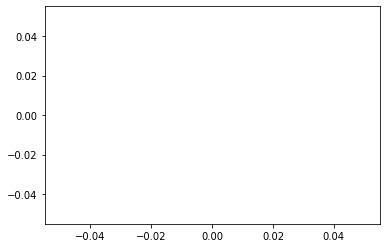

In [58]:
abe_obs_lfc = cd19_screen_anndata_ABE[:, cd19_screen_anndata_ABE.var["ABE_explanable"] == True].var["high_low.lfc.mean"]
abe_obs_cutsite = cd19_screen_anndata_ABE[:, cd19_screen_anndata_ABE.var["ABE_explanable"] == True].var["Cutsite"]

plt.scatter(abe_obs_cutsite, abe_obs_lfc)
plt.show()

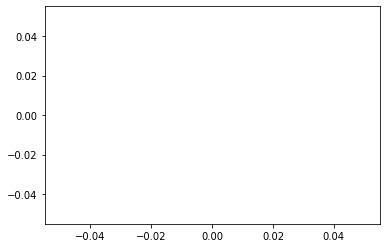

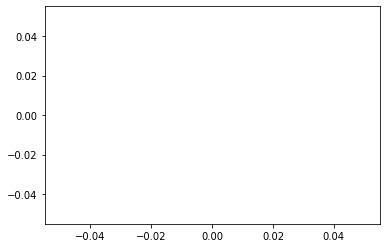

In [59]:
cbe_obs_lfc = cd19_screen_anndata_CBE[:, cd19_screen_anndata_CBE.var["sgRNA_Type_CBE"] == "observation"].var["high_low.lfc.mean"]
cbe_obs_cutsite = cd19_screen_anndata_CBE[:, cd19_screen_anndata_CBE.var["sgRNA_Type_CBE"] == "observation"].var["Cutsite"]

plt.scatter(cbe_obs_cutsite, cbe_obs_lfc)
plt.show()

cbe_obs_lfc = cd19_screen_anndata_CBE[:, cd19_screen_anndata_CBE.var["CBE_explanable"] == True].var["high_low.lfc.mean"]
cbe_obs_cutsite = cd19_screen_anndata_CBE[:, cd19_screen_anndata_CBE.var["CBE_explanable"] == True].var["Cutsite"]

plt.scatter(cbe_obs_cutsite, cbe_obs_lfc)
plt.show()

In [60]:
control_population = "low"
sample_population = "high"

In [135]:
cd19_screen_anndata_ABE

AnnData object with n_obs × n_vars = 9 × 206
    obs: 'sample_name', 'population', 'replicate', 'guide_read_mapping_rate'
    var: 'Chr', 'Start', 'Stop', 'sgRNA_Sequence', 'Strand', 'sgRNA_Type_ABE', 'sgRNA_Type_CBE', 'Cutsite', 'amplicon_position', 'pam', 'is_ngn', 'is_ngg', 'is_nnn', 'is_ABE', 'is_CBE', 'is_ABE_editable', 'is_CBE_editable', 'ABE_explanable', 'CBE_explanable', 'high_low.lfc.mean'
    layers: 'lognorm_counts'

In [136]:
def get_guide_sets(screen_anndata, control_population, sample_population, sample_type_col, explanable_col):
    observation_guides: List[Guide] = []
    negative_guides: List[Guide] = []
    positive_guides: List[Guide] = []
    for row_id, row in enumerate(screen_anndata.transpose()):
        control_raw_count_reps = row[:, screen_anndata.obs["population"] == control_population].X[0]
        sample_raw_count_reps = row[:, screen_anndata.obs["population"] == sample_population].X[0]

        position = None if np.isnan(row.obs["Cutsite"][0]) else int(row.obs["Cutsite"][0]) 
        guide_obj = Guide(identifier=row_id, position=position, sample_population_raw_count_reps=control_raw_count_reps, control_population_raw_count_reps=sample_raw_count_reps, is_explanatory=row.obs[explanable_col][0])
        guide_obj.amplicon_position = row.obs["amplicon_position"][0]
        guide_obj.annotations = (row_id, row)
        if row.obs[sample_type_col][0] == "observation":
            observation_guides.append(guide_obj)
        elif row.obs[sample_type_col][0] == "negative_control":
            negative_guides.append(guide_obj)
        elif row.obs[sample_type_col][0] == "positive_control":
            positive_guides.append(guide_obj)
            
    return (observation_guides, negative_guides, positive_guides)

In [137]:
cd19_screen_anndata_ABE.transpose()

AnnData object with n_obs × n_vars = 206 × 9
    obs: 'Chr', 'Start', 'Stop', 'sgRNA_Sequence', 'Strand', 'sgRNA_Type_ABE', 'sgRNA_Type_CBE', 'Cutsite', 'amplicon_position', 'pam', 'is_ngn', 'is_ngg', 'is_nnn', 'is_ABE', 'is_CBE', 'is_ABE_editable', 'is_CBE_editable', 'ABE_explanable', 'CBE_explanable', 'high_low.lfc.mean'
    var: 'sample_name', 'population', 'replicate', 'guide_read_mapping_rate'
    layers: 'lognorm_counts'

In [138]:
observation_guides_ABE, negative_guides_ABE, positive_guides_ABE = get_guide_sets(screen_anndata=cd19_screen_anndata_ABE, control_population="low", sample_population="high", sample_type_col="sgRNA_Type_ABE", explanable_col="ABE_explanable")
observation_guides_CBE, negative_guides_CBE, positive_guides_CBE = get_guide_sets(screen_anndata=cd19_screen_anndata_CBE, control_population="low", sample_population="high", sample_type_col="sgRNA_Type_CBE", explanable_col="CBE_explanable")

In [139]:
cd19_screen_anndata_CBE.var

,Chr,Start,Stop,sgRNA_Sequence,Strand,sgRNA_Type_ABE,sgRNA_Type_CBE,Cutsite,amplicon_position,pam,is_ngn,is_ngg,is_nnn,is_ABE,is_CBE,is_ABE_editable,is_CBE_editable,ABE_explanable,CBE_explanable,high_low.lfc.mean
sgRNA_Sequence,,,,,,,,,,,,,,,,,,,,
GGGGAATGACATGCTCTAGT,chr16,28930678.0,28930701.0,GGGGAATGACATGCTCTAGT,+,observation,observation,28930692.0,42.0,GAA,False,False,True,True,False,True,False,True,False,-0.327938
GAATGACATGCTCTAGTGAA,chr16,28930681.0,28930704.0,GAATGACATGCTCTAGTGAA,+,observation,observation,28930695.0,45.0,AGC,True,False,True,True,True,True,False,True,False,-0.952296
TGACATGCTCTAGTGAAAGC,chr16,28930684.0,28930707.0,TGACATGCTCTAGTGAAAGC,+,observation,observation,28930698.0,48.0,CAG,False,False,True,True,True,True,False,True,False,0.320067
CATGCTCTAGTGAAAGCCAG,chr16,28930687.0,28930710.0,CATGCTCTAGTGAAAGCCAG,+,observation,observation,28930701.0,51.0,TCT,False,False,True,True,True,True,False,True,False,-0.357371
GCTCTAGTGAAAGCCAGTCT,chr16,28930690.0,28930713.0,GCTCTAGTGAAAGCCAGTCT,+,observation,observation,28930704.0,54.0,GGG,True,True,True,True,True,True,True,True,True,-0.929738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CCACCTTATATTCCCAGGGC,chr19:55_115_773-55_115_973,NaN,NaN,CCACCTTATATTCCCAGGGC,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False,0.309395
TATAAGGTGGTCCCAGCTCG,chr19:55_115_773-55_115_973,NaN,NaN,TATAAGGTGGTCCCAGCTCG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,False,True,False,True,False,1.359756
CGGGGACACAGGATCCCTGG,chr19:55_115_773-55_115_973,NaN,NaN,CGGGGACACAGGATCCCTGG,NaN,negative_control,negative_control,NaN,NaN,None,False,False,True,True,True,True,False,True,False,-0.455721


In [140]:
cd19_screen_anndata_ABE[cd19_screen_anndata_ABE.obs["population"] == control_population, :].X.sum(axis=0)
cd19_screen_anndata_ABE[cd19_screen_anndata_ABE.obs["population"] == sample_population, :].X.sum(axis=0)

ArrayView([  75530.,   85481.,   80042.,  150020.,  201176.,  128341.,
            237113.,  232419.,  217952.,  568998.,  195795.,  118828.,
            200383.,   38582.,   17756.,   66830.,   90860.,  115030.,
            156112.,   98951.,   82328.,   67570.,  232983.,  118077.,
             85972.,   42841.,  167788.,  163688.,  177033.,  261223.,
            378972.,  311345.,  242127.,  381593.,  171300.,  110469.,
            257015.,  309569.,  107108.,  257632.,  188243.,  298891.,
            426481.,  280986.,  220464., 2437806.,  170057.,  269728.,
            265181.,  179942.,   17855.,  278625.,  216301.,  493115.,
            391859.,  225860.,   96889.,  114014.,  325540.,  513942.,
            254667.,  243196.,  392459.,  246045.,  257272.,   92748.,
             70280.,  151778.,  120691.,  127656.,  252522.,  155887.,
            158696.,  352671.,  353317.,  184366.,  168947.,  284849.,
            100900.,  209289.,  189832.,  231149.,  226883.,  107474.,
      

In [141]:
gDNA_amount = 100 
cell_amount = gDNA_amount/6.4 * 1000
# NOTE 5/15/23: For the package, the amount also depends on the VCN
def get_scaling_factors(screen_anndata, control_population, sample_population, cell_amount):
    control_scaling_factors = screen_anndata[screen_anndata.obs["population"] == control_population, :].X.sum(axis=1) / cell_amount
    sample_scaling_factors = screen_anndata[screen_anndata.obs["population"] == sample_population, :].X.sum(axis=1) / cell_amount
    return (control_scaling_factors, sample_scaling_factors)

In [142]:
cell_amount

15625.0

In [143]:
cd19_abe8e_scaling_factors_control, cd19_abe8e_scaling_factors_sample = get_scaling_factors(screen_anndata=cd19_screen_anndata_ABE, control_population=control_population, sample_population=sample_population, cell_amount=cell_amount)
cd19_evocda_scaling_factors_control, cd19_evocda_scaling_factors_sample = get_scaling_factors(screen_anndata=cd19_screen_anndata_CBE, control_population=control_population, sample_population=sample_population, cell_amount=cell_amount)

In [144]:
print(f"Scaling factor for ABE8e control: {cd19_abe8e_scaling_factors_control}, and sample: {cd19_abe8e_scaling_factors_sample}")
print(f"Scaling factor for evoCDA control: {cd19_evocda_scaling_factors_control}, and sample: {cd19_evocda_scaling_factors_sample}")

Scaling factor for ABE8e control: [1508.2596   879.99304  967.5125 ], and sample: [ 955.053    953.33496 1162.4187 ]
Scaling factor for evoCDA control: [492.32648 445.92212 305.44672], and sample: [483.03973 510.30106 369.02963]


Optimizing singleton imputation weights
Singleton optimization upper bound: 0.01898772383940497
Tolerance: 1.898772383940497e-05


/PHShome/bfb12/.conda/envs/demultiplex_py38/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


X: [0.00277317], f: 0.6682093342988926
X: [0.00277317], f: 0.6682093342988926
X: [0.00277317], f: 0.6682093342988926
X: [0.00277317], f: 0.6682093342988926


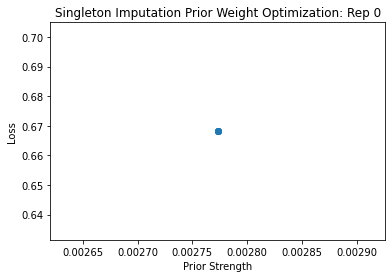

KL Negative Set Average: 0.6676902804692727
KL Positive Set Average: inf
KL Observation Set Average: inf
KL Combined Set Average: 0.6676902804692727
Singleton optimization upper bound: 0.027896605882426997
Tolerance: 2.7896605882427e-05
X: [0.0038672], f: 0.4455142972680545
X: [0.0038672], f: 0.4455142972680545
X: [0.0038672], f: 0.4455142972680545
X: [0.0038672], f: 0.4455142972680545
X: [0.0038672], f: 0.4455142972680545
X: [0.00376462], f: 0.44547921165434373


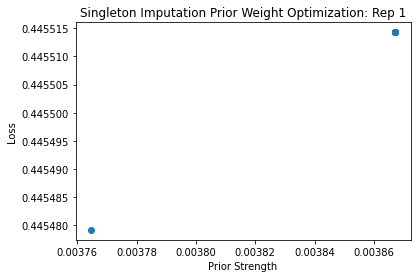

KL Negative Set Average: 0.44544813226617624
KL Positive Set Average: inf
KL Observation Set Average: inf
KL Combined Set Average: 0.44544813226617624
Singleton optimization upper bound: 0.02348329000281993
Tolerance: 2.3483290002819927e-05
X: [0.00193914], f: 0.7995044945664885
X: [0.00193914], f: 0.7995044945664885
X: [0.00230881], f: 0.7885290520781266
X: [0.00242844], f: 0.7881619965289538


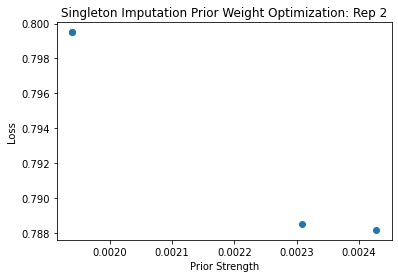

KL Negative Set Average: 0.7881271194103497
KL Positive Set Average: inf
KL Observation Set Average: inf
KL Combined Set Average: 0.7881271194103497
Selected singleton imputation weights: [0.00265426 0.00380611 0.00240085]
Optimizing shrinkage prior weights
X: [53.89125333], f: 2.143403277965132
X: [5.05210017], f: 0.23841406016179345
X: [6.61583665], f: 0.03164728957919638
X: [6.61583665], f: 0.03164728957919638
X: [6.61583665], f: 0.03164728957919638
X: [6.61583665], f: 0.03164728957919638
X: [7.54051344], f: 0.0007277296209345918
X: [7.54051344], f: 0.0007277296209345918
X: [7.54051344], f: 0.0007277296209345918
X: [7.54051344], f: 0.0007277296209345918
X: [7.67814481], f: 3.8835117782687334e-05
X: [7.71619186], f: 3.248779067988039e-07
X: [7.71619186], f: 3.248779067988039e-07
X: [7.71619186], f: 3.248779067988039e-07
X: [7.71619186], f: 3.248779067988039e-07
X: [7.71846778], f: 5.395870916746759e-08
X: [7.71846778], f: 5.395870916746759e-08
X: [7.71846778], f: 5.395870916746759e-0

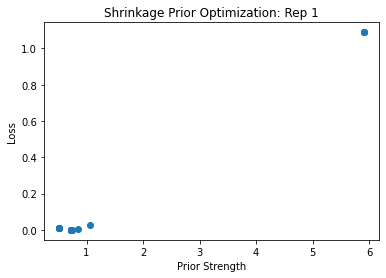

X: [7.43725576], f: 0.0047515214381943505
X: [7.43725576], f: 0.0047515214381943505
X: [7.43725576], f: 0.0047515214381943505
X: [7.43725576], f: 0.0047515214381943505
X: [7.43725576], f: 0.0047515214381943505
X: [7.43725576], f: 0.0047515214381943505
X: [7.43725576], f: 0.0047515214381943505
X: [7.43725576], f: 0.0047515214381943505
X: [7.65040731], f: 0.0006285928319937906
X: [7.65040731], f: 0.0006285928319937906
X: [7.7489781], f: 2.6384252329592073e-05
X: [7.7489781], f: 2.6384252329592073e-05
X: [7.77848297], f: 6.227084409227146e-07
X: [7.77848297], f: 6.227084409227146e-07
X: [7.77848297], f: 6.227084409227146e-07
X: [7.77848297], f: 6.227084409227146e-07
X: [7.77593454], f: 7.730850737353023e-08
X: [7.77407118], f: 9.164510816894733e-09
X: [7.77407118], f: 9.164510816894733e-09
X: [7.77466711], f: 5.672023961622585e-10
X: [7.77448835], f: 1.4503231948737039e-10
X: [7.77456927], f: 1.7505996652289468e-11
X: [7.77456927], f: 1.7505996652289468e-11
X: [7.77456927], f: 1.750599665

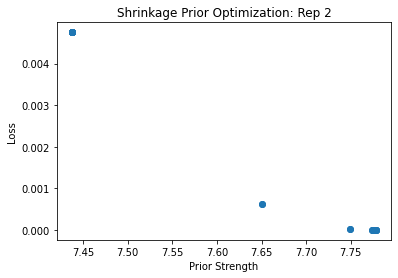

Selected shrinkage prior weights: [7.72003377 0.71946563 7.77454806]
NEGATIVE_CONTROLS
Shrinkage Prior: a=[13.97880325 12.37020852  6.30338285], b=[ 5.56493545 13.6436302  10.2236493 ]
Shrinkage Prior: a=[13.97880325 12.37020852  6.30338285], b=[ 5.56493545 13.6436302  10.2236493 ]
Shrinkage Prior: a=[13.97880325 12.37020852  6.30338285], b=[ 5.56493545 13.6436302  10.2236493 ]
Shrinkage Prior: a=[13.97880325 12.37020852  6.30338285], b=[ 5.56493545 13.6436302  10.2236493 ]
Shrinkage Prior: a=[13.97880325 12.37020852  6.30338285], b=[ 5.56493545 13.6436302  10.2236493 ]
Shrinkage Prior: a=[13.97880325 12.37020852  6.30338285], b=[ 5.56493545 13.6436302  10.2236493 ]
Shrinkage Prior: a=[13.97880325 12.37020852  6.30338285], b=[ 5.56493545 13.6436302  10.2236493 ]
Shrinkage Prior: a=[13.97880325 12.37020852  6.30338285], b=[ 5.56493545 13.6436302  10.2236493 ]
Shrinkage Prior: a=[13.97880325 12.37020852  6.30338285], b=[ 5.56493545 13.6436302  10.2236493 ]
Shrinkage Prior: a=[13.97880325

In [145]:
%%time

cd19_abe8e_high_vs_low_results_noneighborhood = perform_adjustment(
    negative_control_guides = negative_guides_ABE,
    positive_control_guides = positive_guides_ABE,
    observation_guides = observation_guides_ABE,
    num_replicates = 3,
    include_observational_guides_in_fit = True,
    include_positive_control_guides_in_fit = True,
    sample_population_scaling_factors = cd19_abe8e_scaling_factors_sample,
    control_population_scaling_factors = cd19_abe8e_scaling_factors_control,
    monte_carlo_trials = 1000,
    enable_neighborhood_prior =  False,
    neighborhood_bandwidth = 7,
    neighborhood_imputation_prior_strength = None,
    neighborhood_imputation_likelihood_strength = None,
    singleton_imputation_prior_strength = None,
    deviation_weights = np.asarray([1,1,1]),
    KL_guide_set_weights = None,
    shrinkage_prior_strength =  None, 
    posterior_estimator = "mean",
    random_seed = 234,
    cores=100,
    neighborhood_optimization_guide_sample_size = 500
    )

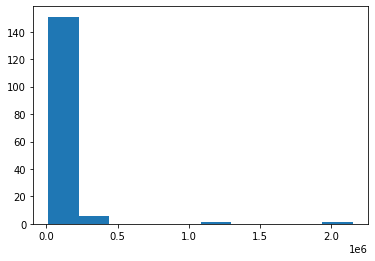

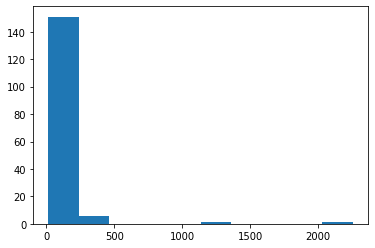

In [77]:
plt.hist([guide.sample_population_raw_count_reps[0] for guide in cd19_abe8e_high_vs_low_results_noneighborhood.adjusted_observation_guides])
plt.show()

plt.hist([guide.sample_population_normalized_count_reps[0] for guide in cd19_abe8e_high_vs_low_results_noneighborhood.adjusted_observation_guides])
plt.show()

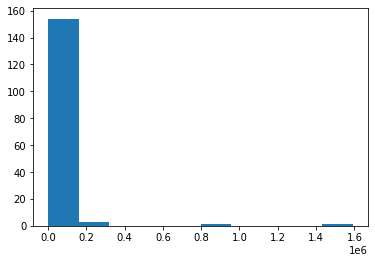

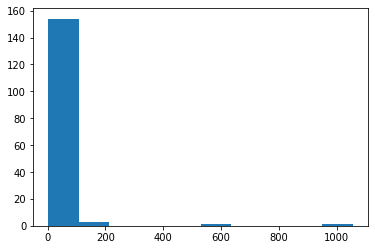

In [78]:
plt.hist([guide.control_population_raw_count_reps[0] for guide in cd19_abe8e_high_vs_low_results_noneighborhood.adjusted_observation_guides])
plt.show()

plt.hist([guide.control_population_normalized_count_reps[0] for guide in cd19_abe8e_high_vs_low_results_noneighborhood.adjusted_observation_guides])
plt.show()

In [79]:
cd19_evocda_scaling_factors_sample

ArrayView([483.03973, 510.30106, 369.02963], dtype=float32)

Optimizing singleton imputation weights
Singleton optimization upper bound: 0.5060871915811574
Tolerance: 0.0005060871915811574


/PHShome/bfb12/.conda/envs/demultiplex_py38/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


X: [0.05042062], f: 0.5672168252812817
X: [0.05042062], f: 0.5672168252812817
X: [0.05042062], f: 0.5672168252812817
X: [0.05042062], f: 0.5672168252812817


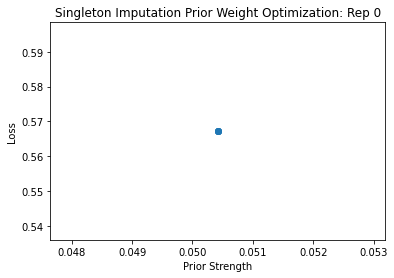

KL Negative Set Average: 0.5660542709159975
KL Positive Set Average: inf
KL Observation Set Average: inf
KL Combined Set Average: 0.5660542709159975
Singleton optimization upper bound: 0.34621676818287656
Tolerance: 0.00034621676818287657
X: [0.02283582], f: 1.1721546468936388
X: [0.01329111], f: 1.128838569278529
X: [0.01511659], f: 1.1227037538408422
X: [0.01551779], f: 1.1225703618027094


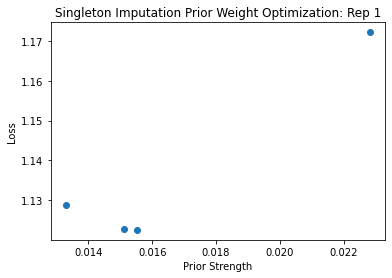

KL Negative Set Average: 1.1225652435300109
KL Positive Set Average: inf
KL Observation Set Average: inf
KL Combined Set Average: 1.1225652435300109
Singleton optimization upper bound: 0.33931858285641087
Tolerance: 0.0003393185828564109
X: [0.02241191], f: 0.865562727257187
X: [0.03013295], f: 0.8589811518740893
X: [0.03013295], f: 0.8589811518740893
X: [0.02874732], f: 0.8568389485595512
X: [0.02874732], f: 0.8568389485595512


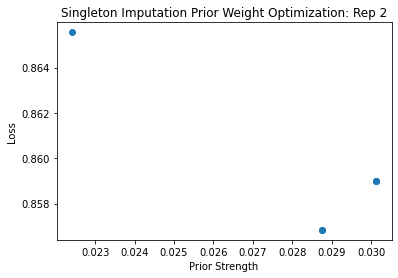

KL Negative Set Average: 0.8559534758474704
KL Positive Set Average: inf
KL Observation Set Average: inf
KL Combined Set Average: 0.8559534758474704
Selected singleton imputation weights: [0.04721607 0.01545259 0.02717269]
Optimizing shrinkage prior weights
X: [12.46233764], f: 27.345382534933858
X: [3.47472241], f: 0.3952720692740319
X: [3.47472241], f: 0.3952720692740319
X: [2.73087248], f: 0.014319839010058066
X: [2.73087248], f: 0.014319839010058066
X: [2.73087248], f: 0.014319839010058066
X: [2.73087248], f: 0.014319839010058066
X: [2.73087248], f: 0.014319839010058066
X: [2.92904122], f: 0.00802831047753605
X: [2.89396314], f: 0.0028200625914589494
X: [2.84292447], f: 1.7165933119400734e-07
X: [2.84292447], f: 1.7165933119400734e-07
X: [2.84292447], f: 1.7165933119400734e-07
X: [2.84292447], f: 1.7165933119400734e-07
X: [2.84292447], f: 1.7165933119400734e-07
X: [2.84292447], f: 1.7165933119400734e-07
X: [2.84324767], f: 5.454307006047543e-09
X: [2.84324767], f: 5.454307006047543

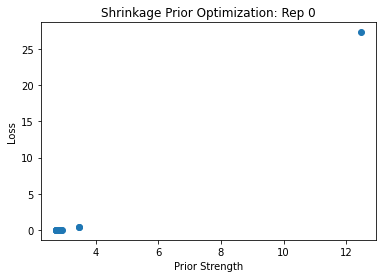

X: [34.90800078], f: 54.335145500729794
X: [10.25592313], f: 19.708356014912162
X: [3.83917183], f: 2.034524401648903
X: [3.83917183], f: 2.034524401648903
X: [3.47510407], f: 1.3083894632144242
X: [3.47510407], f: 1.3083894632144242
X: [2.66750767], f: 0.1931187665317824
X: [1.85248407], f: 0.1690808078258612
X: [2.52419059], f: 0.09086038879828906
X: [2.42141085], f: 0.03987343902287721
X: [2.42141085], f: 0.03987343902287721
X: [2.27795842], f: 0.0028709176194989805
X: [2.25602824], f: 0.0009491053153205531
X: [2.25602824], f: 0.0009491053153205531
X: [2.23449424], f: 6.937254343886146e-05
X: [2.23449424], f: 6.937254343886146e-05
X: [2.22657766], f: 1.2894620926573452e-09
X: [2.22657766], f: 1.2894620926573452e-09
X: [2.22657766], f: 1.2894620926573452e-09
X: [2.22657766], f: 1.2894620926573452e-09
X: [2.22655163], f: 7.428369031003967e-11
X: [2.22655163], f: 7.428369031003967e-11
X: [2.22655163], f: 7.428369031003967e-11
X: [2.22655163], f: 7.428369031003967e-11
X: [2.22655163], f

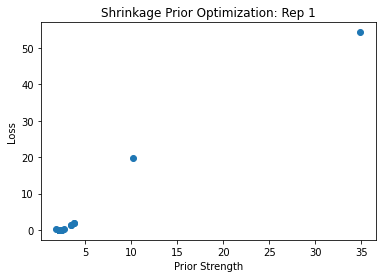

X: [6.17971865], f: 17.120832294435942
X: [6.17971865], f: 17.120832294435942
X: [6.17971865], f: 17.120832294435942
X: [4.72640701], f: 9.972511104131861
X: [2.45418923], f: 0.6756294874465658
X: [2.45418923], f: 0.6756294874465658
X: [2.45418923], f: 0.6756294874465658
X: [2.45418923], f: 0.6756294874465658
X: [1.90283412], f: 4.151380854788833e-05
X: [1.90283412], f: 4.151380854788833e-05
X: [1.90283412], f: 4.151380854788833e-05
X: [1.90283412], f: 4.151380854788833e-05
X: [1.90283412], f: 4.151380854788833e-05
X: [1.90283412], f: 4.151380854788833e-05
X: [1.90283412], f: 4.151380854788833e-05
X: [1.90283412], f: 4.151380854788833e-05
X: [1.9020916], f: 2.7511393820844887e-05
X: [1.89814857], f: 1.25797671612915e-06
X: [1.89814857], f: 1.25797671612915e-06
X: [1.89931379], f: 5.787250292321744e-07
X: [1.89931379], f: 5.787250292321744e-07
X: [1.89905102], f: 1.1311183834017413e-07
X: [1.89893733], f: 2.3309482788391733e-08
X: [1.89882137], f: 1.1996725834961808e-09
X: [1.89883266],

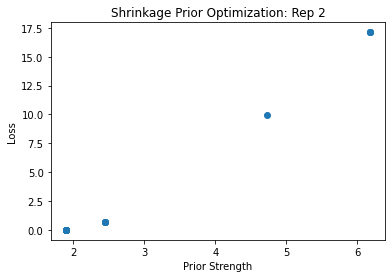

Selected shrinkage prior weights: [2.84331767 2.22654333 1.89884279]
NEGATIVE_CONTROLS
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.00801804]
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.00801804]
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.00801804]
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.00801804]
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.00801804]
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.00801804]
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.00801804]
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.00801804]
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.00801804]
Shrinkage Prior: a=[8.47485561 2.54913637 3.94754235], b=[9.32963208 4.46327036 8.008

In [93]:
%%time

cd19_evocda_high_vs_low_results_noneighborhood_SAFE = perform_adjustment(
    negative_control_guides = negative_guides_CBE,
    positive_control_guides = positive_guides_CBE,
    observation_guides = observation_guides_CBE,
    num_replicates = 3,
    include_observational_guides_in_fit = True,
    include_positive_control_guides_in_fit = True,
    sample_population_scaling_factors = cd19_evocda_scaling_factors_sample,
    control_population_scaling_factors = cd19_evocda_scaling_factors_control,
    monte_carlo_trials = 1000,
    enable_neighborhood_prior =  False,
    neighborhood_bandwidth = 7,
    neighborhood_imputation_prior_strength = None,
    neighborhood_imputation_likelihood_strength = None,
    singleton_imputation_prior_strength = None,
    deviation_weights = np.asarray([1,1,1]),
    KL_guide_set_weights = None,
    shrinkage_prior_strength =  None, 
    posterior_estimator = "mean",
    random_seed = 234,
    cores=75,
    neighborhood_optimization_guide_sample_size = 500
    )

In [176]:
cd19_evocda_high_vs_low_results_noneighborhood_SAFE

In [80]:
import pickle

def save_or_load_pickle(directory, label, py_object = None, date_string = None):
    '''Save a pickle for caching that is notated by the date'''
    
    if date_string == None:
        today = date.today()
        date_string = str(today.year) + ("0" + str(today.month) if today.month < 10 else str(today.month)) + str(today.day)
    
    filename = directory + label + "_" + date_string + '.pickle'
    print(filename)
    if py_object == None:
        with open(filename, 'rb') as handle:
            py_object = pickle.load(handle)
            return py_object
    else:
        with open(filename, 'wb') as handle:
            pickle.dump(py_object, handle, protocol=pickle.HIGHEST_PROTOCOL)

def display_all_pickle_versions(directory, label):
    '''Retrieve all pickles with a label, specifically to identify versions available'''
    return [f for f in listdir(directory) if isfile(join(directory, f)) and label == f[:len(label)]]


In [146]:
cd19_abe8e_high_vs_low_results_noneighborhood
save_or_load_pickle(directory="./20230516_crispr_shrinkage_results/", label="cd19_abe8e_high_vs_low_results_noneighborhood", py_object = cd19_abe8e_high_vs_low_results_noneighborhood, date_string = "20230727")

./20230516_crispr_shrinkage_results/cd19_abe8e_high_vs_low_results_noneighborhood_20230727.pickle


In [94]:
#save_or_load_pickle(directory="./20230516_crispr_shrinkage_results/", label="cd19_abe8e_high_vs_low_results_noneighborhood", py_object = cd19_abe8e_high_vs_low_results_noneighborhood, date_string = "20230517")
save_or_load_pickle(directory="./20230516_crispr_shrinkage_results/", label="cd19_evocda_high_vs_low_results_noneighborhood_SAFE", py_object = cd19_evocda_high_vs_low_results_noneighborhood_SAFE, date_string = "20230727")

./20230516_crispr_shrinkage_results/cd19_evocda_high_vs_low_results_noneighborhood_SAFE_20230727.pickle


In [90]:
#cd19_abe8e_high_vs_low_results_noneighborhood = save_or_load_pickle(directory="./20230516_crispr_shrinkage_results/", label="cd19_abe8e_high_vs_low_results_noneighborhood", date_string = "20230517")
cd19_evocda_high_vs_low_results_noneighborhood = save_or_load_pickle(directory="./20230516_crispr_shrinkage_results/", label="cd19_evocda_high_vs_low_results_noneighborhood", date_string = "20230517")

./20230516_crispr_shrinkage_results/cd19_evocda_high_vs_low_results_noneighborhood_20230517.pickle


ModuleNotFoundError: No module named 'perturb_tools._framework._ScreenModule'

### Visualization

In [95]:
calculate_raw_lfc = lambda guide, rep_i, control_population_negative_control_total_normalized_count, sample_population_negative_control_total_normalized_count: np.log((guide.sample_population_normalized_count_reps[rep_i] * control_population_negative_control_total_normalized_count[rep_i])/(guide.control_population_normalized_count_reps[rep_i] * sample_population_negative_control_total_normalized_count[rep_i]))

def get_lfc(guide, result_obj):
    raw_lfc = calculate_raw_lfc(guide, rep_i, result_obj.negative_control_guide_control_population_total_normalized_counts_reps, result_obj.negative_control_guide_sample_population_total_normalized_counts_reps)
    rescaled_lfc = guide.LFC_estimate_per_replicate_rescaled[rep_i]
    unscaled_lfc = guide.LFC_estimate_per_replicate[rep_i]
    unshrunk_lfc = np.mean(guide.guide_count_LFC_samples_normalized_list)
    total_count = guide.sample_population_normalized_count_reps[rep_i] + guide.control_population_normalized_count_reps[rep_i]
    return (raw_lfc, rescaled_lfc, unscaled_lfc, unshrunk_lfc, total_count)


/PHShome/bfb12/.conda/envs/demultiplex_py38/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


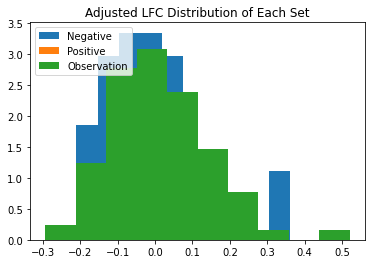

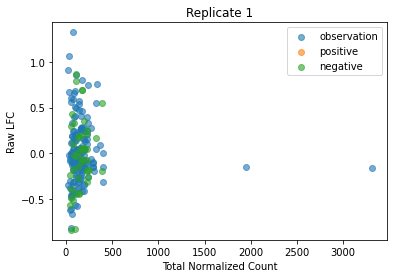

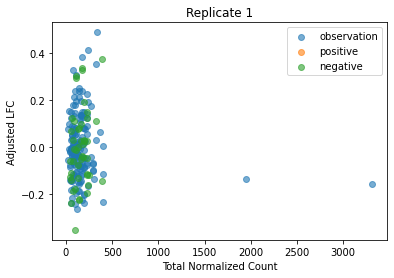

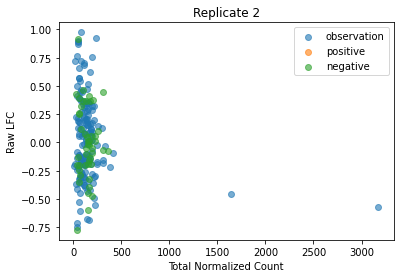

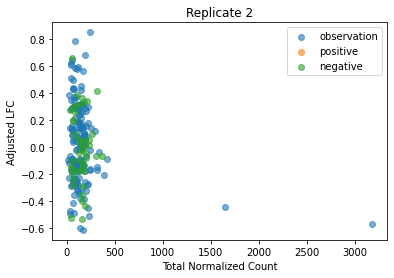

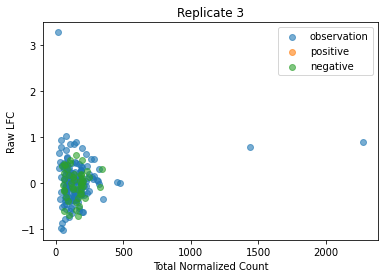

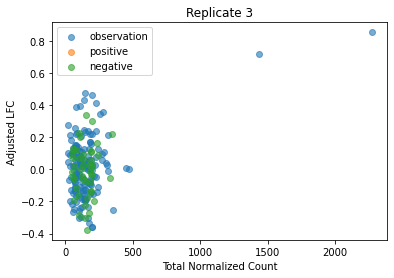

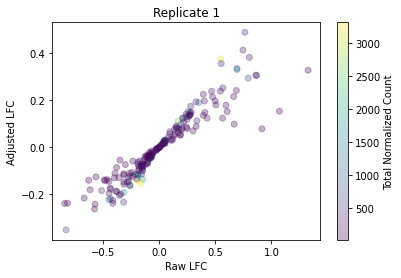

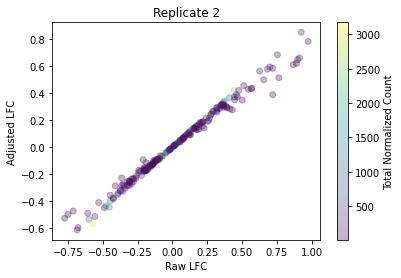

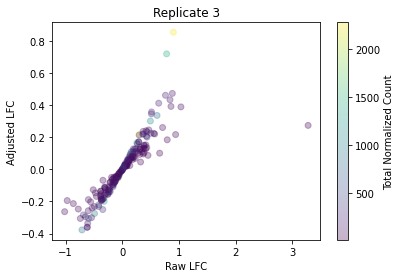

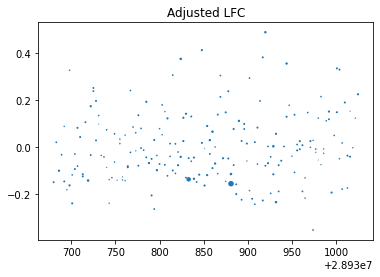

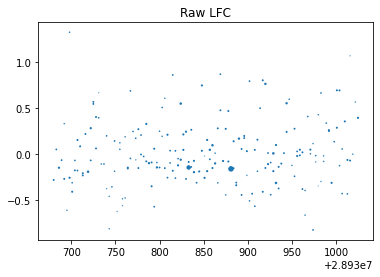

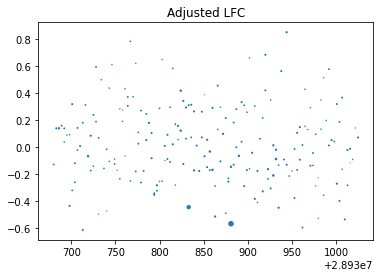

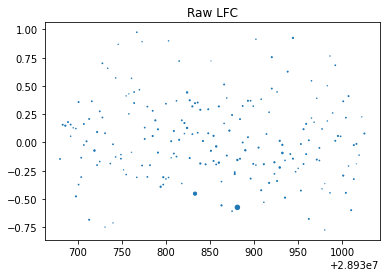

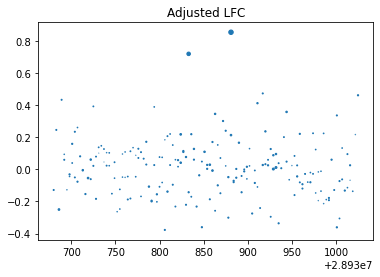

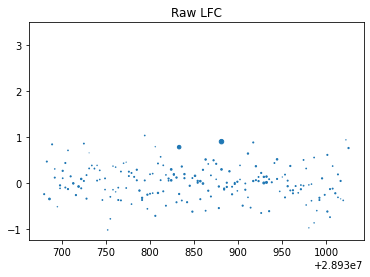

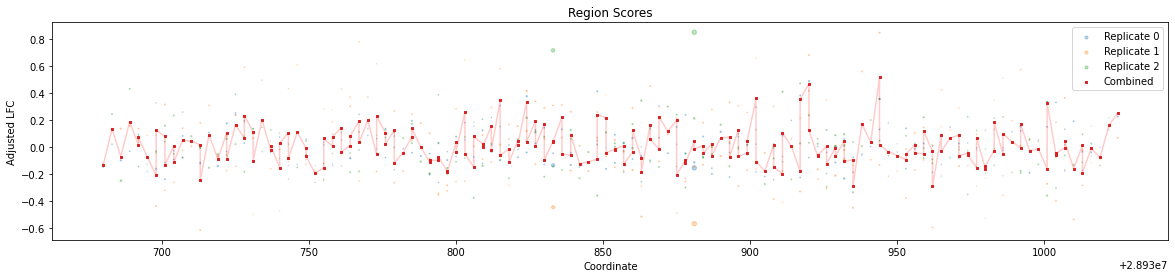

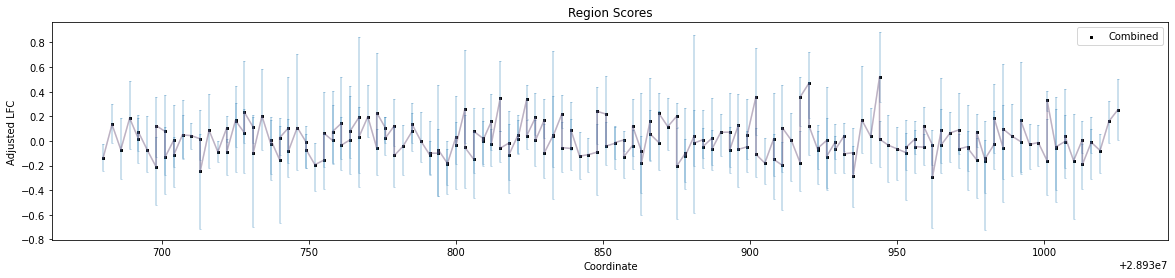

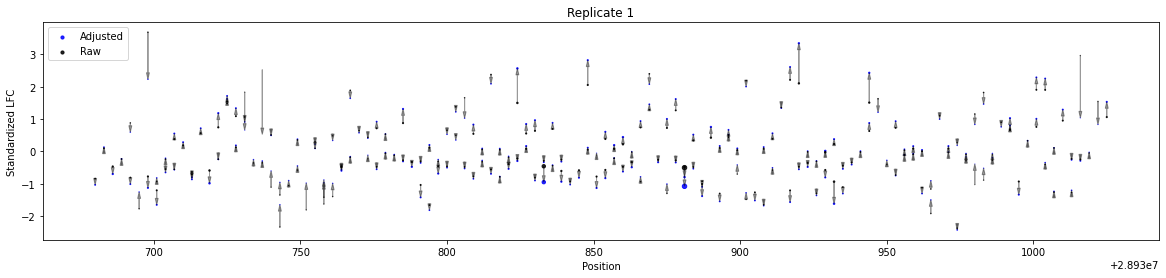

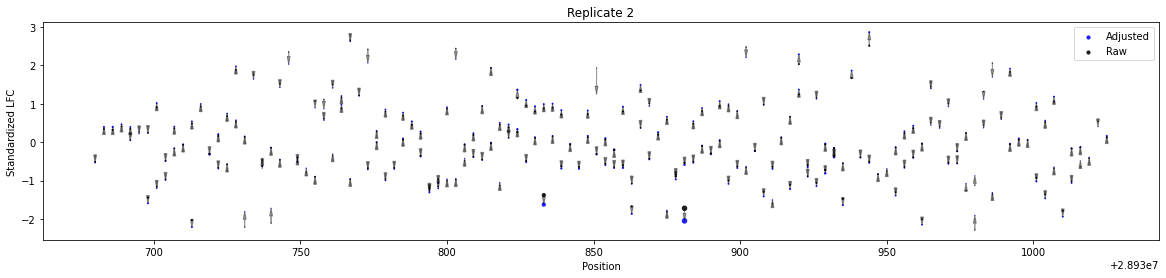

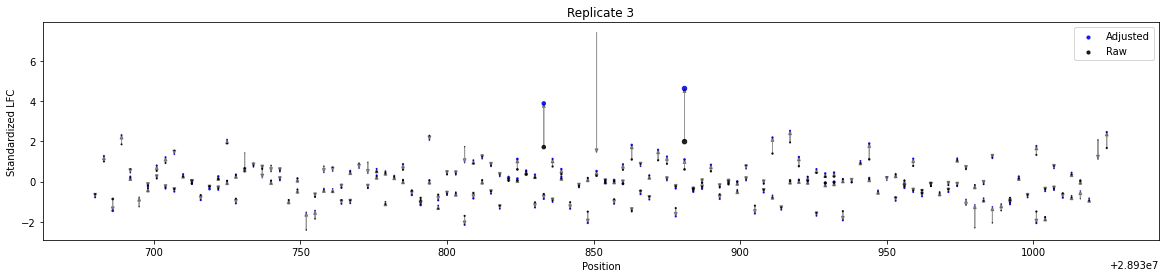

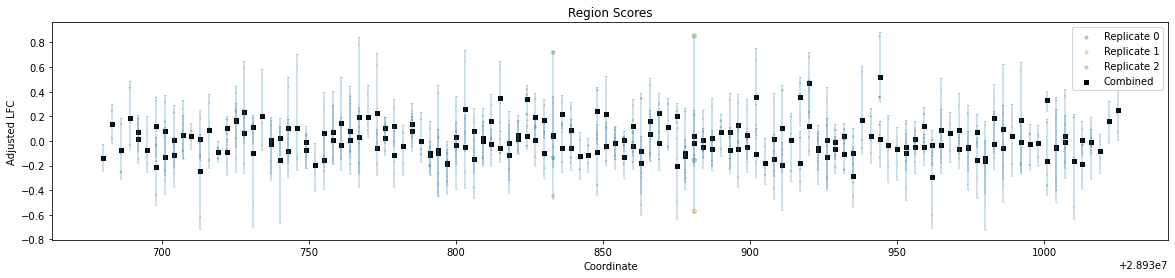

In [147]:
cd19_abe8e_high_vs_low_results_noneighborhood_visualization_input = prepare_crispr_shrinkage_visualization_input(cd19_abe8e_high_vs_low_results_noneighborhood, use_rescaled=True)
visualize_all(cd19_abe8e_high_vs_low_results_noneighborhood_visualization_input, max_shape_size=20)

In [88]:
cd19_evocda_high_vs_low_results_noneighborhood_visualization_input = prepare_crispr_shrinkage_visualization_input(cd19_evocda_high_vs_low_results_noneighborhood, use_rescaled=True)
visualize_all(cd19_evocda_high_vs_low_results_noneighborhood_visualization_input, max_shape_size=20)

NameError: name 'cd19_evocda_high_vs_low_results_noneighborhood' is not defined

/PHShome/bfb12/.conda/envs/demultiplex_py38/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


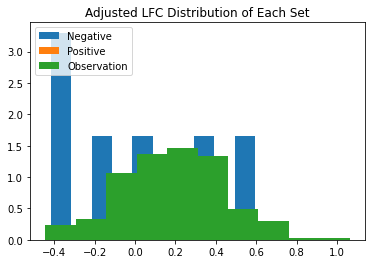

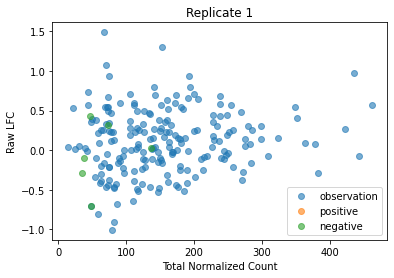

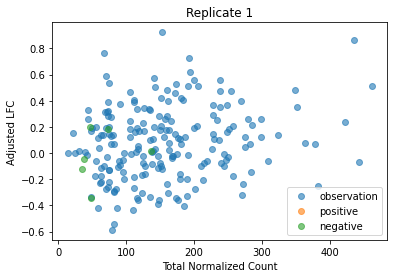

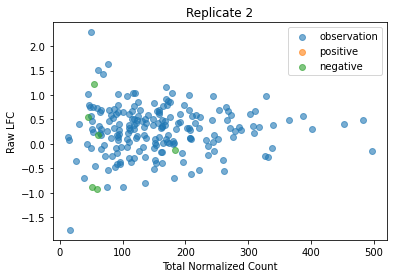

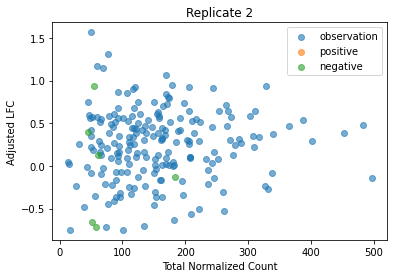

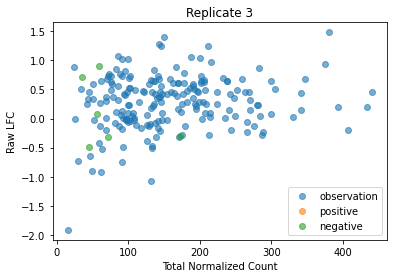

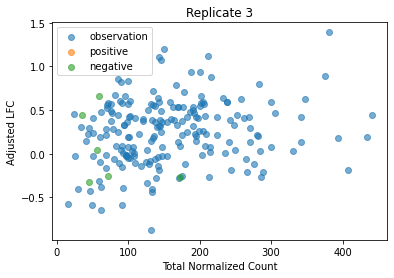

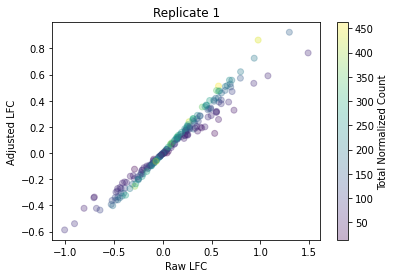

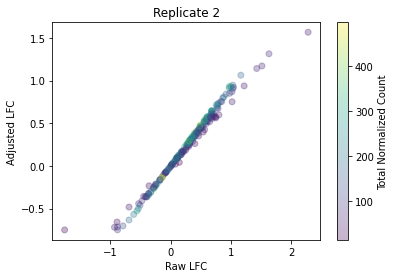

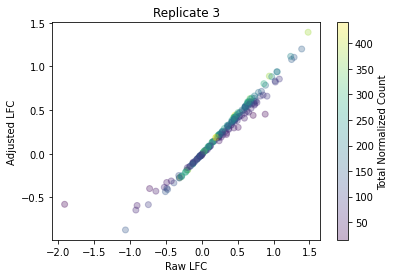

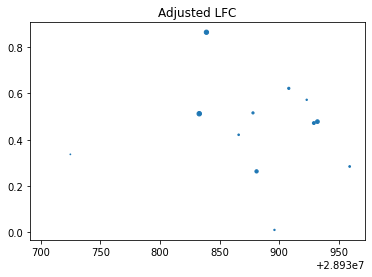

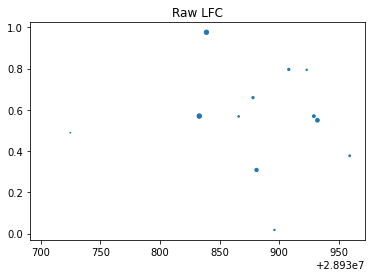

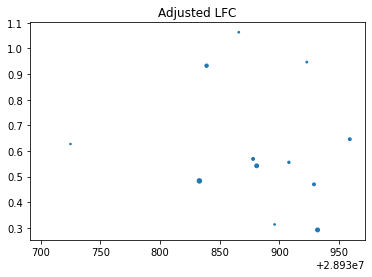

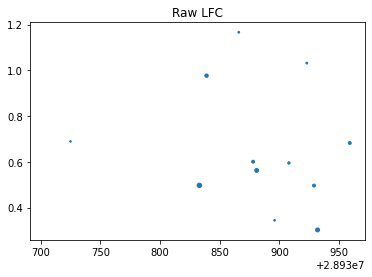

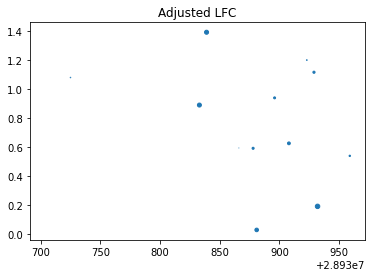

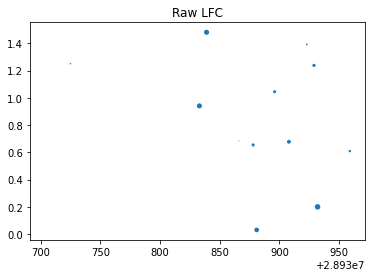

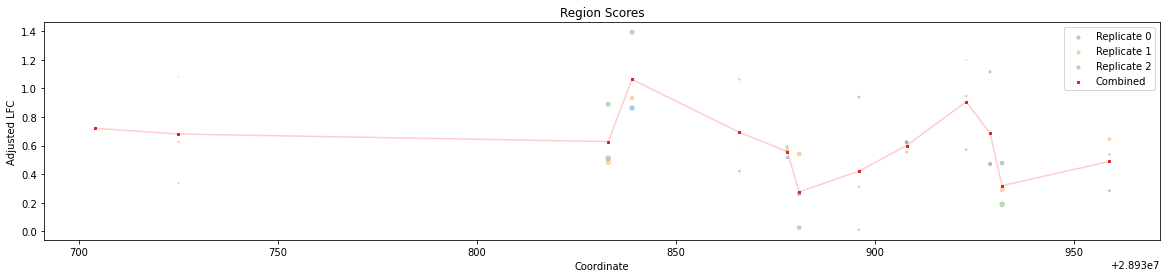

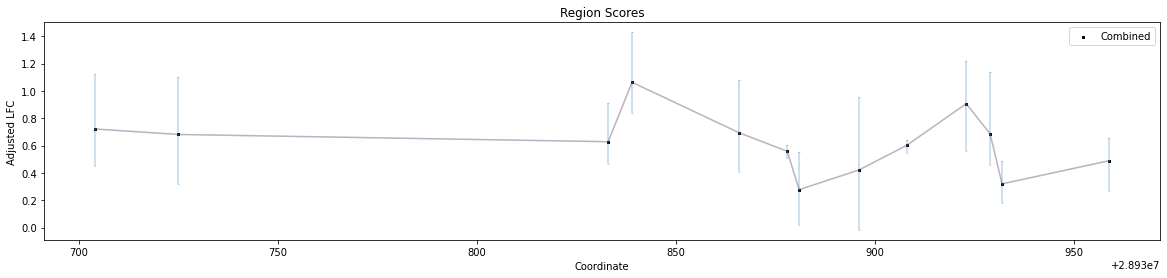

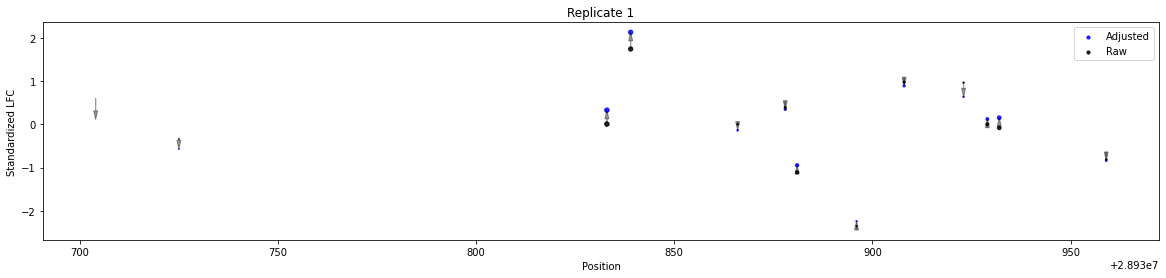

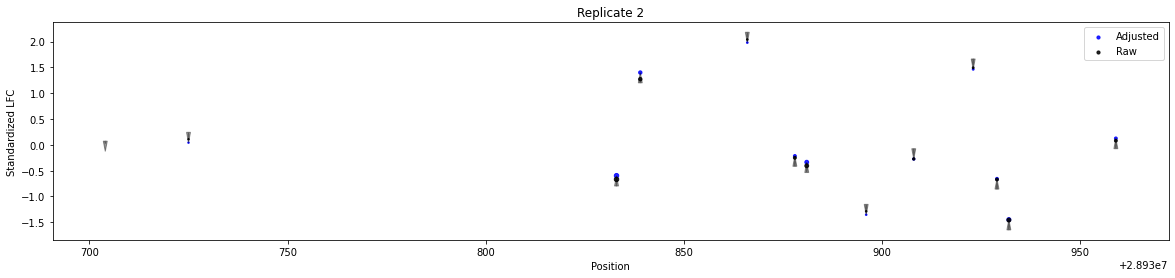

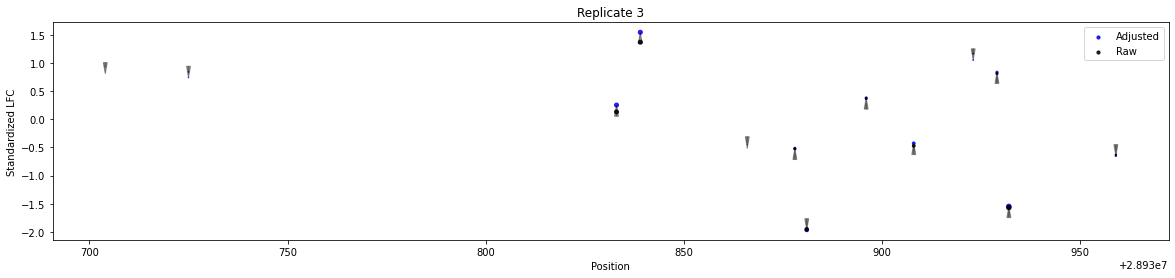

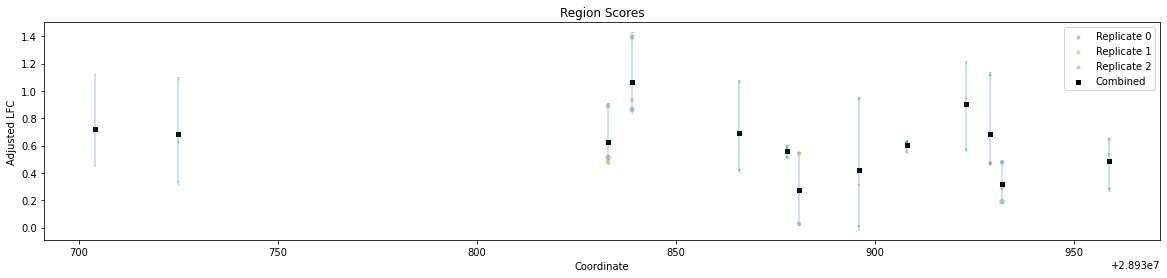

In [96]:
cd19_evocda_high_vs_low_results_noneighborhood_visualization_input_SAFE = prepare_crispr_shrinkage_visualization_input(cd19_evocda_high_vs_low_results_noneighborhood_SAFE, use_rescaled=True)
visualize_all(cd19_evocda_high_vs_low_results_noneighborhood_visualization_input_SAFE, max_shape_size=20)

In [97]:
from typing import List, Union, Tuple
def normalize_shape_size(input_shape_sizes: List[Union[int,float]], max_shape_size: Union[int,float], all_shape_sizes: Union[List[Union[int,float]], None] = None):
    input_shape_sizes = np.asarray(input_shape_sizes)
    if all_shape_sizes is None:
        all_shape_sizes = input_shape_sizes
    else:
        all_shape_sizes = np.asarray(all_shape_sizes)
        
    return ((input_shape_sizes - all_shape_sizes.min()) / (all_shape_sizes.max() - all_shape_sizes.min())) * max_shape_size

def visualize_raw_and_adjusted_score_by_position_scatter(crispr_shrinkage_visualization_input_list, input_label_list: List[str], max_shape_size = 10):
    assert len(crispr_shrinkage_visualization_input_list) > 0, "Input list must be greater than 0"
    assert len(crispr_shrinkage_visualization_input_list) == len(input_label_list), "Label list must be the same size as the input list"

    
    
    for rep_i in crispr_shrinkage_visualization_input_list[0].replicate_indices:
        fig, axs = plt.subplots(2, 1, figsize=(20, 8))
        for input_index in range(len(crispr_shrinkage_visualization_input_list)):
            crispr_shrinkage_visualization_input = crispr_shrinkage_visualization_input_list[input_index]
            input_label = input_label_list[input_index] 
            
            normalized_count = normalize_shape_size(input_shape_sizes=crispr_shrinkage_visualization_input.explanatory_count_rep[rep_i], all_shape_sizes=np.concatenate([crispr_shrinkage_visualization_input_i.explanatory_count_rep[rep_i] for crispr_shrinkage_visualization_input_i in crispr_shrinkage_visualization_input_list]), max_shape_size=max_shape_size)
            axs[0].scatter(crispr_shrinkage_visualization_input.explanatory_positions, crispr_shrinkage_visualization_input.explanatory_lfc_rep[rep_i], s=normalized_count, label=input_label)
            axs[0].set_title("Adjusted LFC")
            
            axs[1].scatter(crispr_shrinkage_visualization_input.explanatory_positions, crispr_shrinkage_visualization_input.explanatory_raw_lfc_rep[rep_i], s=normalized_count, label=input_label)
            axs[1].set_title("Raw LFC")
            axs[1].set_label(input_label)
        axs[0].legend()
        axs[1].legend()
        
        fig.suptitle("Replicate: {}".format(rep_i+1))
        plt.show()
           
            #plt.show()

       
#visualize_raw_and_adjusted_score_by_position_scatter([cd19_evocda_plasmid_vs_presort_results_visualization_input, cd19_evocda_plasmid_vs_presort_results_noneighborhood_visualization_input], ["neighbor", "no neighbor"], max_shape_size = 15)

In [98]:
import matplotlib.cm as cm
from matplotlib import markers
import random



marker_styles = markers.MarkerStyle.markers.keys()
marker_dict = {i: style for i, style in enumerate(marker_styles)}

def visualize_combined_adjusted_score_by_position_scatter(crispr_shrinkage_visualization_input_list, input_label_list: List[str], title, positive_labels: List[List], negative_labels: List[List], max_shape_size = 10, threshold=0, amplicon_position=False, legend=True, yaxis_label="Adjusted LFC", xaxis_label="Coordinate", xlim=None,ylim=None, null_intervals=None, reverse_sign=False, plot_replicates=False, plot_CI=True, save_fn=None, figsize=(20, 4)):
    fig = plt.figure(figsize=figsize)
    fig.suptitle("{} - Enrichment Scores".format(title))
    ax = fig.add_subplot(111)
    for input_index, crispr_shrinkage_visualization_input in enumerate(crispr_shrinkage_visualization_input_list):
        guide_prob0 = np.asarray([guide.LFC_estimate_combined_prob0_rescaled for guide in crispr_shrinkage_visualization_input.explanatory_guides])
        guide_prob_null_interval = np.asarray([guide.LFC_estimate_combined_prob_null_interval_rescaled for guide in crispr_shrinkage_visualization_input.explanatory_guides])
        LFC_estimate_combined_prob_greater_null_rescaled_all = np.asarray([guide.LFC_estimate_combined_prob_greater_null_rescaled for guide in crispr_shrinkage_visualization_input.explanatory_guides])
        LFC_estimate_combined_prob_lesser_null_rescaled_all = np.asarray([guide.LFC_estimate_combined_prob_lesser_null_rescaled for guide in crispr_shrinkage_visualization_input.explanatory_guides])
        LFC_estimate_combined_prob_differential_null_rescaled_all = np.asarray([np.max([guide.LFC_estimate_combined_prob_greater_null_rescaled, guide.LFC_estimate_combined_prob_lesser_null_rescaled]) for guide in crispr_shrinkage_visualization_input.explanatory_guides])
        scaled_prob = (LFC_estimate_combined_prob_differential_null_rescaled_all-0.5)*2
        scaled_prob = np.where(scaled_prob<0, 0, scaled_prob)
        
        if amplicon_position == True:
            explanatory_positions = np.asarray([guide.amplicon_position for guide in crispr_shrinkage_visualization_input.explanatory_guides])
        else:
            explanatory_positions = np.asarray(crispr_shrinkage_visualization_input.explanatory_positions)
            
        explanatory_lfc = np.asarray(crispr_shrinkage_visualization_input.explanatory_lfc) 
        explanatory_lfc_CI_low = np.asarray([CI[0] for CI in crispr_shrinkage_visualization_input.explanatory_lfc_CI]) 
        explanatory_lfc_CI_up = np.asarray([CI[1] for CI in crispr_shrinkage_visualization_input.explanatory_lfc_CI]) 
        explanatory_lfc_rep = crispr_shrinkage_visualization_input.explanatory_lfc_rep  
        explanatory_count_rep=crispr_shrinkage_visualization_input.explanatory_count_rep 
        
        #passed_threshold = (1-guide_prob_null_interval) >= threshold
        #guide_prob0 = guide_prob0[passed_threshold]
        #guide_prob_null_interval = guide_prob_null_interval[passed_threshold]
        #explanatory_positions=explanatory_positions[passed_threshold]
        #explanatory_lfc=explanatory_lfc[passed_threshold]
        #explanatory_lfc_CI_low=explanatory_lfc_CI_low[passed_threshold]
        #explanatory_lfc_CI_up=explanatory_lfc_CI_up[passed_threshold]
        #explanatory_lfc_rep=explanatory_lfc_rep[:,passed_threshold]
        
        #for rep_i in crispr_shrinkage_visualization_input.replicate_indices:
        #    ax.scatter(explanatory_positions, explanatory_lfc_rep[rep_i], s=normalize_shape_size(input_shape_sizes=explanatory_count_rep[rep_i], all_shape_sizes=np.concatenate([explanatory_count_rep[rep_i] for rep_i in crispr_shrinkage_visualization_input.replicate_indices]), max_shape_size=max_shape_size), alpha=0.3, color=cm.hot(input_index/len(crispr_shrinkage_visualization_input_list)), marker="o", label="{} - Replicate {}".format(input_label_list[input_index], rep_i))
        multiplier = 1
        if reverse_sign:
            multiplier = -1
            
        if plot_replicates:
            for rep_i in range(3):
                normalized_count = normalize_shape_size(input_shape_sizes=explanatory_count_rep[rep_i], all_shape_sizes=explanatory_count_rep[rep_i], max_shape_size=max_shape_size)
                ax.scatter(explanatory_positions, explanatory_lfc_rep[rep_i]*multiplier, s=normalized_count, alpha=scaled_prob)
            
        ax.scatter(explanatory_positions, explanatory_lfc*multiplier, alpha=scaled_prob, marker="s", s=40, color=cm.hot(input_index/len(crispr_shrinkage_visualization_input_list)), label="{}".format(input_label_list[input_index]))
        if plot_CI:
            markers, caps, bars = ax.errorbar(explanatory_positions, explanatory_lfc*multiplier, (explanatory_lfc-explanatory_lfc_CI_low, explanatory_lfc_CI_up-explanatory_lfc), alpha=0.2, color=cm.hot(input_index/len(crispr_shrinkage_visualization_input_list)), solid_capstyle='projecting', capsize=1, linestyle='')

        # ADD ANNOTATIONS:
        for guide_index, guide in enumerate(crispr_shrinkage_visualization_input.explanatory_guides):
            if guide.identifier in positive_labels[input_index]:
                #ax.scatter(explanatory_positions[guide_index], explanatory_lfc[guide_index]*-1, alpha=scaled_prob[guide_index], marker="s", s=40, color=cm.hot(input_index/len(crispr_shrinkage_visualization_input_list)))
                jitter = random.uniform(-0.4, 0.4)
                ax.text(explanatory_positions[guide_index], 1.3 + jitter, f"{guide.identifier}", ha="center", va="center", fontsize=8, color="green")
                ax.plot([explanatory_positions[guide_index], explanatory_positions[guide_index] ], [-1.25, 1.25 + jitter], "--", color="green", alpha=0.5, lw=0.5)
            elif guide.identifier in negative_labels[input_index]:
                jitter = random.uniform(-0.4, 0.4)
                ax.text(explanatory_positions[guide_index], -1.3 + jitter, f"{guide.identifier}", ha="center", va="center", fontsize=8, color="red")
                ax.plot([explanatory_positions[guide_index], explanatory_positions[guide_index] ], [1.25, -1.25 + jitter], "--", color="red", alpha=0.5, lw=0.5)
            
        ax.axhline(y = 0, color = 'grey', alpha=0.3)
        if null_intervals:
            ax.axhline(y = null_intervals[0], color = 'grey', linestyle = '--', alpha=0.3)
            ax.axhline(y = null_intervals[1], color = 'grey', linestyle = '--', alpha=0.3)
        ax.set_xlabel(xaxis_label)
        ax.set_ylabel(yaxis_label)
        if xlim:
            ax.set_xlim(xlim[0], xlim[1])
        if ylim:
            ax.set_ylim(ylim[0], ylim[1])
        if xlim:
            ax.set_xticks(np.arange(xlim[0], xlim[1], 10))
        else:
            if amplicon_position == True:
                ax.set_xticks(np.arange(0, max(explanatory_positions)+1, 10))
            else:
                ax.set_xticks(np.arange(min(explanatory_positions), max(explanatory_positions)+1, 10))
        if legend:
            leg = ax.legend()
            for lh in leg.legend_handles: 
                lh.set_alpha(1)
        if save_fn != None:
            fig.savefig(save_fn)
        
    plt.show()

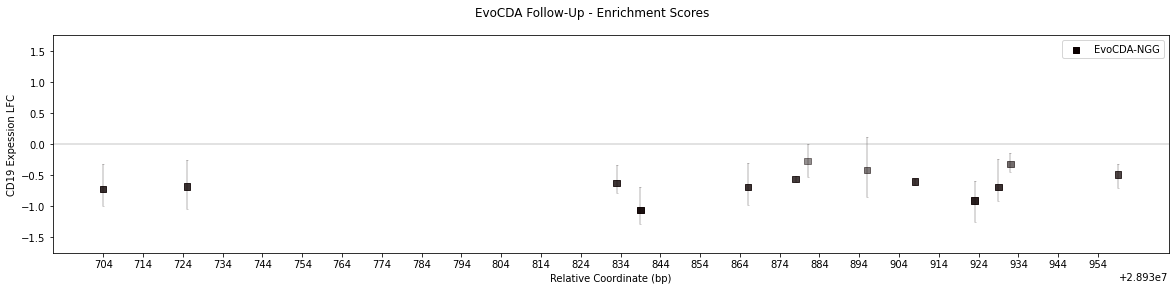

In [100]:
# Test the chosen gRNAs:
# Show ABE8e and evoCDA overlayed
evocda_positive_guides = [104, 137, 93, 20, 44,156]
evocda_negative_guides = [133, 89, 108, 85]
evocda_negative_guides_lefthit = [19]

evocda_total_positive_guides = evocda_positive_guides
evocda_total_negative_guides = evocda_negative_guides + evocda_negative_guides_lefthit
visualize_combined_adjusted_score_by_position_scatter([cd19_evocda_high_vs_low_results_noneighborhood_visualization_input_SAFE], ["EvoCDA-NGG"], "EvoCDA Follow-Up", positive_labels = [evocda_total_positive_guides], negative_labels=[evocda_total_negative_guides], max_shape_size = 50, amplicon_position=False, legend=True, xaxis_label="Relative Coordinate (bp)", yaxis_label="CD19 Expession LFC", ylim=(-1.75, 1.75), reverse_sign = True, plot_replicates=False, save_fn="20230321_count_based_results.pdf")

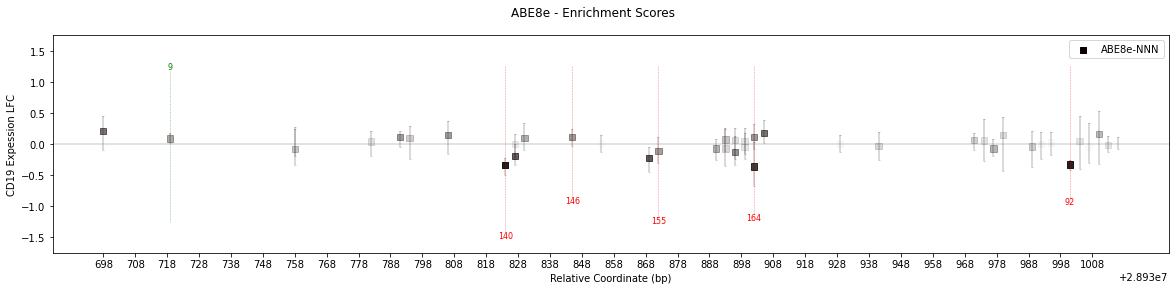

In [106]:
abe8e_positive_guides = [166, 102,  33,  70, 144, 114, 101, 139,   9,  48,   8, 132, 103,18,  97, 142,   3, 158,  67,  17, 171,  42,  83]
abe8e_negative_guides = [130, 134, 110,   6, 156,  57,  15, 177, 183, 145,  29,  24, 182, 75, 155,  72,  52,  92, 150,  69]
abe8e_zim3_negative_guides = [164, 169]
abe8e_pax5_negative_guides = [135, 136, 137, 138, 140, 143, 145, 146]
abe8e_bcl11a_negative_guides = [94, 96, 99]

# TODO (4/6/2023): Create volcano plot, and label guides that way. Can be a good figure for paper

abe8e_all_positive_guides = abe8e_positive_guides
abe8e_all_negative_guides = abe8e_negative_guides+abe8e_zim3_negative_guides + abe8e_pax5_negative_guides + abe8e_bcl11a_negative_guides
visualize_combined_adjusted_score_by_position_scatter([cd19_abe8e_high_vs_low_results_noneighborhood_visualization_input], ["ABE8e-NNN"], "ABE8e", positive_labels = [abe8e_all_positive_guides], negative_labels=[abe8e_all_negative_guides], max_shape_size = 50, amplicon_position=False, legend=True, xaxis_label="Relative Coordinate (bp)", yaxis_label="CD19 Expession LFC", ylim=(-1.75, 1.75), reverse_sign = True, plot_replicates=False, save_fn="20230321_count_based_results.pdf")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

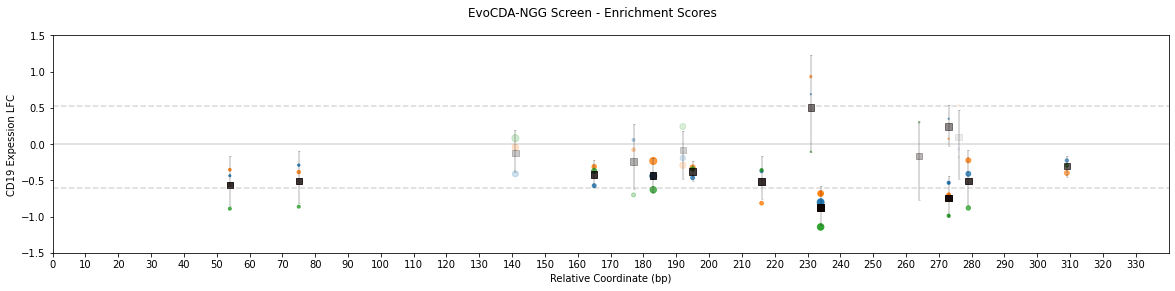

In [93]:
# Show "evoCDA" enrichment scatter
visualize_combined_adjusted_score_by_position_scatter([cd19_evocda_high_vs_low_results_noneighborhood_visualization_input], [""], "EvoCDA-NGG Screen", null_intervals = cd19_evocda_high_vs_low_results_noneighborhood.LFC_rescaled_null_interval, reverse_sign=True, max_shape_size = 50, positive_labels=[[]], negative_labels=[[]], amplicon_position=True, legend=False, xaxis_label="Relative Coordinate (bp)", yaxis_label="CD19 Expession LFC", xlim=(0, 340), ylim=(-1.5, 1.5),  plot_replicates=True, save_fn="cd19_evocda_cd19_scatter.pdf")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

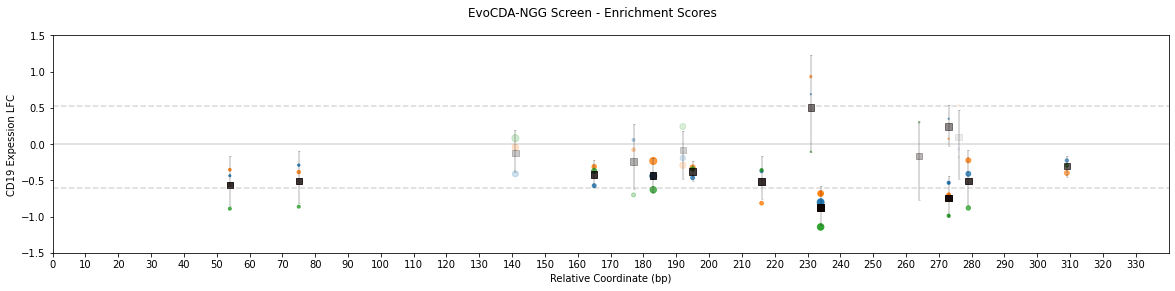

In [94]:
# Show "evoCDA" enrichment scatter
visualize_combined_adjusted_score_by_position_scatter([cd19_evocda_high_vs_low_results_noneighborhood_visualization_input], [""], "EvoCDA-NGG Screen", null_intervals = cd19_evocda_high_vs_low_results_noneighborhood.LFC_rescaled_null_interval, reverse_sign=True, max_shape_size = 50, positive_labels=[[]], negative_labels=[[]], amplicon_position=True, legend=False, xaxis_label="Relative Coordinate (bp)", yaxis_label="CD19 Expession LFC", xlim=(0, 340), ylim=(-1.5, 1.5),  plot_replicates=True, save_fn="cd19_evocda_cd19_scatter.pdf")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

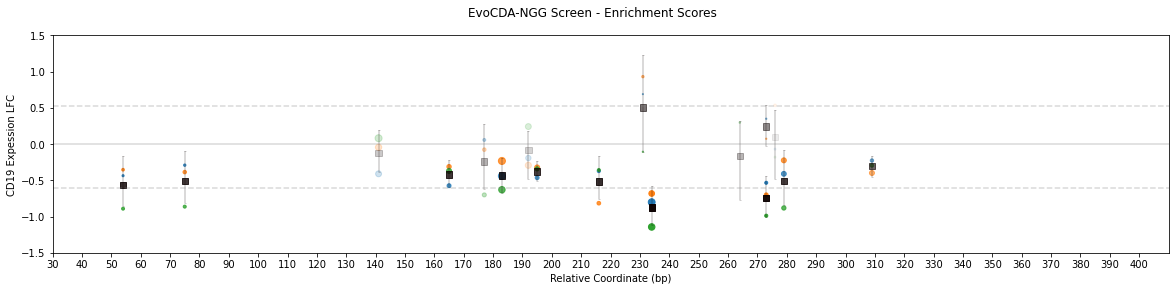

In [95]:
# Show "evoCDA" enrichment scatter
visualize_combined_adjusted_score_by_position_scatter([cd19_evocda_high_vs_low_results_noneighborhood_visualization_input], [""], "EvoCDA-NGG Screen", null_intervals = cd19_evocda_high_vs_low_results_noneighborhood.LFC_rescaled_null_interval, max_shape_size = 50, reverse_sign=True, positive_labels=[[]], negative_labels=[[]], amplicon_position=True, legend=False, xaxis_label="Relative Coordinate (bp)", yaxis_label="CD19 Expession LFC", xlim=(30, 410), ylim=(-1.5, 1.5),  plot_replicates=True, save_fn="cd19_evocda_cd19_scatter.pdf")

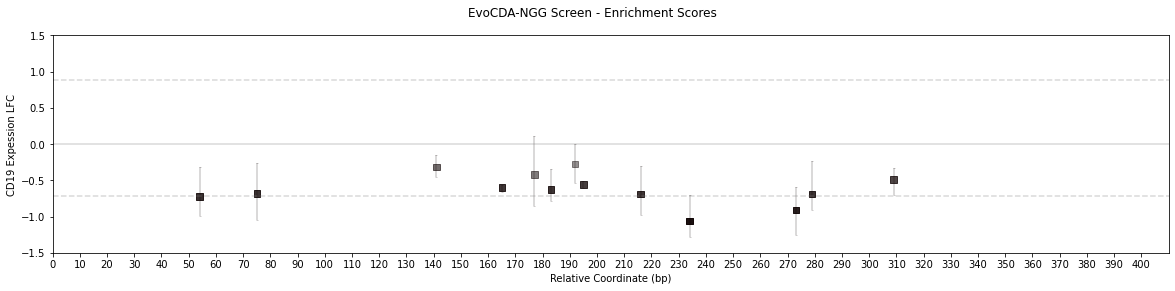

In [114]:
# Show "evoCDA" enrichment scatter
visualize_combined_adjusted_score_by_position_scatter([cd19_evocda_high_vs_low_results_noneighborhood_visualization_input_SAFE], [""], "EvoCDA-NGG Screen", null_intervals = cd19_evocda_high_vs_low_results_noneighborhood_SAFE.LFC_rescaled_null_interval, max_shape_size = 50, reverse_sign=True, positive_labels=[[]], negative_labels=[[]], amplicon_position=True, legend=False, xaxis_label="Relative Coordinate (bp)", yaxis_label="CD19 Expession LFC", xlim=(0, 410), ylim=(-1.5, 1.5),  plot_replicates=False, save_fn="cd19_evocda_cd19_scatter.pdf")

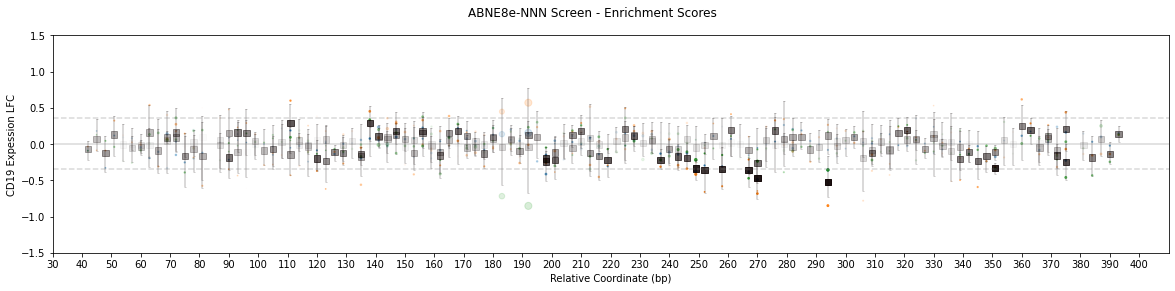

In [148]:
# Show "evoCDA" enrichment scatter
visualize_combined_adjusted_score_by_position_scatter([cd19_abe8e_high_vs_low_results_noneighborhood_visualization_input], [""], "ABNE8e-NNN Screen", null_intervals = cd19_abe8e_high_vs_low_results_noneighborhood.LFC_rescaled_null_interval, max_shape_size = 50, positive_labels=[[]], negative_labels=[[]], amplicon_position=True, legend=False, xaxis_label="Relative Coordinate (bp)", yaxis_label="CD19 Expession LFC", xlim=(30, 410), ylim=(-1.5, 1.5),  reverse_sign=True, plot_replicates=True, save_fn="cd19_evocda_cd19_scatter.pdf")

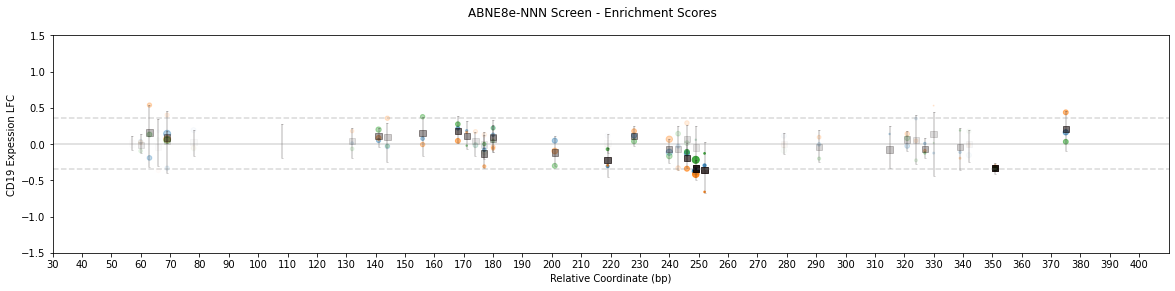

In [113]:
# Show "evoCDA" enrichment scatter
visualize_combined_adjusted_score_by_position_scatter([cd19_abe8e_high_vs_low_results_noneighborhood_visualization_input], [""], "ABNE8e-NNN Screen", null_intervals = cd19_abe8e_high_vs_low_results_noneighborhood.LFC_rescaled_null_interval, max_shape_size = 50, positive_labels=[[]], negative_labels=[[]], amplicon_position=True, legend=False, xaxis_label="Relative Coordinate (bp)", yaxis_label="CD19 Expession LFC", xlim=(30, 410), ylim=(-1.5, 1.5),  reverse_sign=True, plot_replicates=True, save_fn="cd19_evocda_cd19_scatter.pdf")

In [79]:
def visualize_standardized_adjusted_score_by_position_scatter(crispr_shrinkage_visualization_input, max_shape_size=10):
    explanatory_lfc_CI_low = np.asarray([CI[0] for CI in crispr_shrinkage_visualization_input.explanatory_lfc_CI])
    explanatory_lfc_CI_up = np.asarray([CI[1] for CI in crispr_shrinkage_visualization_input.explanatory_lfc_CI])
    
    
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111)

    for rep_i in crispr_shrinkage_visualization_input.replicate_indices:
        ax.scatter(crispr_shrinkage_visualization_input.explanatory_positions, crispr_shrinkage_visualization_input.explanatory_lfc_rep[rep_i], s=normalize_shape_size(input_shape_sizes=crispr_shrinkage_visualization_input.explanatory_count_rep[rep_i], max_shape_size=max_shape_size), alpha=0.3, label="Replicate {}".format(rep_i))
    ax.scatter(crispr_shrinkage_visualization_input.explanatory_positions, crispr_shrinkage_visualization_input.explanatory_lfc, marker="s",color="black", s=10, label="Combined")
    ax.errorbar(crispr_shrinkage_visualization_input.explanatory_positions, crispr_shrinkage_visualization_input.explanatory_lfc, (crispr_shrinkage_visualization_input.explanatory_lfc-explanatory_lfc_CI_low, explanatory_lfc_CI_up-crispr_shrinkage_visualization_input.explanatory_lfc), solid_capstyle='projecting', capsize=1, alpha=0.3, linestyle='')

    ax.set_title("Region Scores")
    ax.set_xlabel("Coordinate")
    ax.set_ylabel("Adjusted LFC")
    ax.legend()
    plt.show()
    
    
def visualize_standardized_adjusted_score_by_position_scatter_all(crispr_shrinkage_visualization_input, max_shape_size=10):
    
    def plot_single_group(ax, lfc_CI: Tuple[float, float], positions: List, lfc_rep, count_rep, lfc, label=""):
        lfc_CI_low = np.asarray([CI[0] for CI in lfc_CI])
        lfc_CI_up = np.asarray([CI[1] for CI in lfc_CI])


        

        for rep_i in crispr_shrinkage_visualization_input.replicate_indices:
            ax.scatter(positions, lfc_rep[rep_i], s=normalize_shape_size(input_shape_sizes=count_rep[rep_i], max_shape_size=max_shape_size), alpha=0.3, label=f"Replicate {rep_i} - {label}")
        ax.scatter(positions, lfc, marker="s", s=10, label=f"Combined {label}")
        ax.errorbar(positions, lfc, (lfc-lfc_CI_low, lfc_CI_up-lfc), solid_capstyle='projecting', capsize=1, alpha=0.3, linestyle='')

        
        
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111)
    plot_single_group(ax=ax, lfc_CI=crispr_shrinkage_visualization_input.observational_lfc_CI, positions=crispr_shrinkage_visualization_input.observational_positions, lfc_rep=crispr_shrinkage_visualization_input.observational_lfc_rep, count_rep=crispr_shrinkage_visualization_input.observational_count_rep, lfc=crispr_shrinkage_visualization_input.observational_lfc, label="observation")
    plot_single_group(ax=ax, lfc_CI=crispr_shrinkage_visualization_input.negative_control_lfc_CI, positions=crispr_shrinkage_visualization_input.negative_control_positions, lfc_rep=crispr_shrinkage_visualization_input.negative_control_lfc_rep, count_rep=crispr_shrinkage_visualization_input.negative_control_count_rep, lfc=crispr_shrinkage_visualization_input.negative_control_lfc, label="negative control")
    
    ax.set_title("Region Scores")
    ax.set_xlabel("Coordinate")
    ax.set_ylabel("Adjusted LFC")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

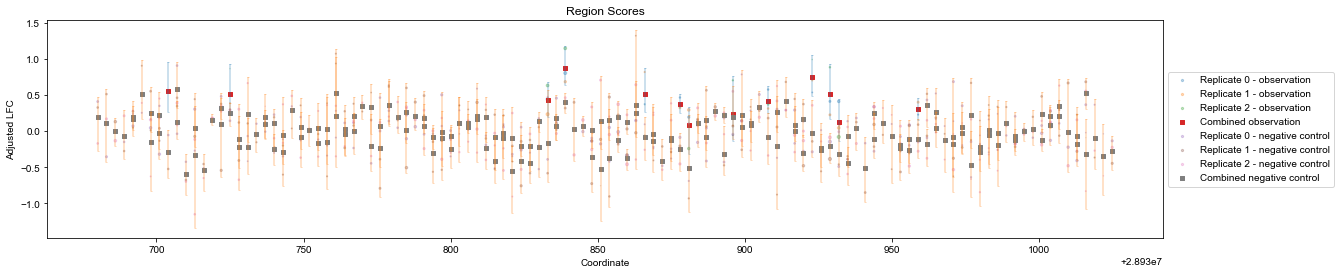

In [537]:
visualize_standardized_adjusted_score_by_position_scatter_all(cd19_evocda_high_vs_low_results_noneighborhood_visualization_input)

/PHShome/bfb12/.conda/envs/demultiplex_py38/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/PHShome/bfb12/.conda/envs/demultiplex_py38/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


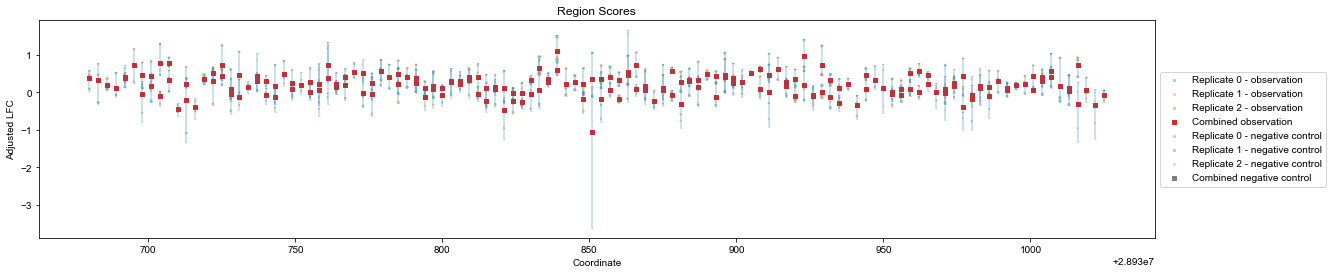

In [677]:
visualize_standardized_adjusted_score_by_position_scatter_all(cd19_evocda_high_vs_low_results_noneighborhood_visualization_input)

### Create Table

In [445]:
value_labels = ["identifier", "genome_position", f"{sample_population}_population_raw_count_reps_1", f"{sample_population}_population_raw_count_reps_2", f"{sample_population}_population_raw_count_reps_3", f"{control_population}_population_raw_count_reps_1", f"{control_population}_population_raw_count_reps_2", f"{control_population}_population_raw_count_reps_3", "is_explanatory", "amplicon_position", f"{sample_population}_normalized_count_reps", f"{control_population}_normalized_count_reps","LFC_estimate_combined", "LFC_estimate_per_replicate", "LFC_estimate_combined_CI","LFC_estimate_combined_std", "LFC_estimate_per_replicate_CI", "LFC_estimate_per_replicate_std","differential_probability","LFC_estimate_combined_prob0", "LFC_estimate_combined_prob_lt0", "LFC_estimate_combined_prob_gt0","LFC_estimate_per_replicate_prob0", "LFC_estimate_per_replicate_lt0","LFC_estimate_per_replicate_gt0", "LFC_estimate_combined_rescaled", "LFC_estimate_per_replicate_rescaled","LFC_estimate_combined_CI_rescaled", "LFC_estimate_combined_std_rescaled", "LFC_estimate_per_replicate_CI_rescaled","LFC_estimate_per_replicate_std_rescaled", "LFC_estimate_combined_prob0_rescaled","LFC_estimate_combined_prob_lt0_rescaled", "LFC_estimate_combined_prob_gt0_rescaled","LFC_estimate_per_replicate_prob0_rescaled", "LFC_estimate_per_replicate_lt0_rescaled","LFC_estimate_per_replicate_gt0_rescaled", "LFC_estimate_combined_prob_null_interval_rescaled","LFC_estimate_combined_prob_null_interval", "LFC_estimate_per_replicate_prob_null_interval_rescaled","LFC_estimate_per_replicate_prob_null_interval", "LFC_estimate_combined_prob_greater_null_rescaled","LFC_estimate_combined_prob_lesser_null_rescaled", "LFC_estimate_combined_prob_greater_null","LFC_estimate_combined_prob_lesser_null", "LFC_estimate_per_replicate_prob_greater_null_rescaled","LFC_estimate_per_replicate_prob_lesser_null_rescaled", "LFC_estimate_per_replicate_prob_greater_null","LFC_estimate_per_replicate_prob_lesser_null"]

def generate_report(guide_set: List):
    scaled_prob = lambda guide: (max(guide.LFC_estimate_combined_prob_greater_null_rescaled, guide.LFC_estimate_combined_prob_lesser_null_rescaled)-0.5)*2
    value_list = [(guide.identifier, guide.position, guide.sample_population_raw_count_reps[0], guide.sample_population_raw_count_reps[1], guide.sample_population_raw_count_reps[2], guide.control_population_raw_count_reps[0], guide.control_population_raw_count_reps[1], guide.control_population_raw_count_reps[2], guide.is_explanatory, guide.amplicon_position, list(guide.sample_population_normalized_count_reps), list(guide.control_population_normalized_count_reps),guide.LFC_estimate_combined, list(guide.LFC_estimate_per_replicate), guide.LFC_estimate_combined_CI,guide.LFC_estimate_combined_std, list(guide.LFC_estimate_per_replicate_CI), list(guide.LFC_estimate_per_replicate_std), scaled_prob(guide), guide.LFC_estimate_combined_prob0, guide.LFC_estimate_combined_prob_lt0, guide.LFC_estimate_combined_prob_gt0,list(guide.LFC_estimate_per_replicate_prob0), list(guide.LFC_estimate_per_replicate_lt0),list(guide.LFC_estimate_per_replicate_gt0), guide.LFC_estimate_combined_rescaled, list(guide.LFC_estimate_per_replicate_rescaled),guide.LFC_estimate_combined_CI_rescaled, guide.LFC_estimate_combined_std_rescaled, list(guide.LFC_estimate_per_replicate_CI_rescaled),list(guide.LFC_estimate_per_replicate_std_rescaled), guide.LFC_estimate_combined_prob0_rescaled,guide.LFC_estimate_combined_prob_lt0_rescaled, guide.LFC_estimate_combined_prob_gt0_rescaled,list(guide.LFC_estimate_per_replicate_prob0_rescaled), list(guide.LFC_estimate_per_replicate_lt0_rescaled),list(guide.LFC_estimate_per_replicate_gt0_rescaled), guide.LFC_estimate_combined_prob_null_interval_rescaled,guide.LFC_estimate_combined_prob_null_interval, list(guide.LFC_estimate_per_replicate_prob_null_interval_rescaled),list(guide.LFC_estimate_per_replicate_prob_null_interval), guide.LFC_estimate_combined_prob_greater_null_rescaled,guide.LFC_estimate_combined_prob_lesser_null_rescaled, guide.LFC_estimate_combined_prob_greater_null,guide.LFC_estimate_combined_prob_lesser_null, list(guide.LFC_estimate_per_replicate_prob_greater_null_rescaled),list(guide.LFC_estimate_per_replicate_prob_lesser_null_rescaled), list(guide.LFC_estimate_per_replicate_prob_greater_null),list(guide.LFC_estimate_per_replicate_prob_lesser_null)) for guide in guide_set]
    crispr_shrinkage_df = pd.DataFrame(value_list, columns=value_labels)
    annotation_df = pd.DataFrame([guide.annotations[1].guides.iloc[0] for guide in guide_set])
    return pd.concat([annotation_df.reset_index(drop=True), crispr_shrinkage_df.reset_index(drop=True)], axis=1)

def generate_complete_report(result_obj):
    negative_df = generate_report(result_obj.adjusted_negative_control_guides)
    positive_df = generate_report(result_obj.adjusted_positive_control_guides)
    observation_df = generate_report(result_obj.adjusted_observation_guides)
    return negative_df, positive_df, observation_df 

cd19_evocda_high_vs_low_results_noneighborhood_report_negative_df, cd19_evocda_high_vs_low_results_noneighborhood_report_positive_df, cd19_evocda_high_vs_low_results_noneighborhood_report_observation_df = generate_complete_report(cd19_evocda_high_vs_low_results_noneighborhood)
cd19_abe8e_high_vs_low_results_noneighborhood_report_negative_df, cd19_abe8e_high_vs_low_results_noneighborhood_report_positive_df, cd19_abe8e_high_vs_low_results_noneighborhood_report_observation_df = generate_complete_report(cd19_abe8e_high_vs_low_results_noneighborhood)

In [446]:
cd19_evocda_high_vs_low_results_noneighborhood_report_negative_df

,Chr,Start,Stop,sgRNA_Sequence,Strand,sgRNA_Type_ABE,sgRNA_Type_CBE,Cutsite,amplicon_position,pam,...,LFC_estimate_per_replicate_prob_null_interval_rescaled,LFC_estimate_per_replicate_prob_null_interval,LFC_estimate_combined_prob_greater_null_rescaled,LFC_estimate_combined_prob_lesser_null_rescaled,LFC_estimate_combined_prob_greater_null,LFC_estimate_combined_prob_lesser_null,LFC_estimate_per_replicate_prob_greater_null_rescaled,LFC_estimate_per_replicate_prob_lesser_null_rescaled,LFC_estimate_per_replicate_prob_greater_null,LFC_estimate_per_replicate_prob_lesser_null
0,chr16,28930678.0,28930701.0,GGGGAATGACATGCTCTAGT,+,observation,negative_control,28930692.0,42.0,GAA,...,"[1.0, 1.0, 0.984]","[0.934, 1.0, 0.888]",0.686000,0.314000,0.680667,0.319333,"[0.805, 0.536, 0.794]","[0.195, 0.464, 0.206]","[0.738, 0.553, 0.76]","[0.262, 0.447, 0.24]"
1,chr16,28930681.0,28930704.0,GAATGACATGCTCTAGTGAA,+,observation,negative_control,28930695.0,45.0,AGC,...,"[1.0, 0.002, 0.846]","[0.921, 0.131, 0.774]",0.883667,0.116333,0.858000,0.142000,"[0.819, 0.987, 0.875]","[0.181, 0.013, 0.125]","[0.775, 0.98, 0.837]","[0.225, 0.02, 0.163]"
2,chr16,28930684.0,28930707.0,TGACATGCTCTAGTGAAAGC,+,observation,negative_control,28930698.0,48.0,CAG,...,"[1.0, 1.0, 0.551]","[0.965, 1.0, 0.596]",0.433333,0.566667,0.415000,0.585000,"[0.74, 0.521, 0.077]","[0.26, 0.479, 0.923]","[0.691, 0.529, 0.116]","[0.309, 0.471, 0.884]"
3,chr16,28930687.0,28930710.0,CATGCTCTAGTGAAAGCCAG,+,observation,negative_control,28930701.0,51.0,TCT,...,"[0.963, 1.0, 0.687]","[0.836, 0.999, 0.719]",0.717000,0.283000,0.686667,0.313333,"[0.903, 0.349, 0.918]","[0.097, 0.651, 0.082]","[0.852, 0.393, 0.871]","[0.148, 0.607, 0.129]"
4,chr16,28930693.0,28930716.0,CTAGTGAAAGCCAGTCTGGG,+,observation,negative_control,28930707.0,57.0,CAG,...,"[1.0, 1.0, 1.0]","[0.999, 0.993, 1.0]",0.634000,0.366000,0.629000,0.371000,"[0.487, 0.827, 0.592]","[0.513, 0.173, 0.408]","[0.484, 0.801, 0.602]","[0.516, 0.199, 0.398]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,chr19:55_115_773-55_115_973,NaN,NaN,CCACCTTATATTCCCAGGGC,NaN,negative_control,negative_control,NaN,NaN,None,...,"[0.997, 1.0, 0.998]","[0.978, 0.998, 0.983]",0.370000,0.630000,0.412667,0.587333,"[0.384, 0.435, 0.322]","[0.616, 0.565, 0.678]","[0.42, 0.441, 0.363]","[0.58, 0.559, 0.637]"
189,chr19:55_115_773-55_115_973,NaN,NaN,TATAAGGTGGTCCCAGCTCG,NaN,negative_control,negative_control,NaN,NaN,None,...,"[0.667, 0.371, 0.814]","[0.677, 0.438, 0.793]",0.099333,0.900667,0.118000,0.882000,"[0.094, 0.048, 0.122]","[0.906, 0.952, 0.878]","[0.128, 0.069, 0.123]","[0.872, 0.931, 0.877]"
190,chr19:55_115_773-55_115_973,NaN,NaN,CGGGGACACAGGATCCCTGG,NaN,negative_control,negative_control,NaN,NaN,None,...,"[1.0, 1.0, 0.931]","[0.947, 0.979, 0.81]",0.735000,0.265000,0.676333,0.323667,"[0.734, 0.673, 0.789]","[0.266, 0.327, 0.211]","[0.687, 0.651, 0.761]","[0.313, 0.349, 0.239]"
191,chr19:55_115_773-55_115_973,NaN,NaN,TGCTGTCCTGAAGTGGACAT,NaN,negative_control,negative_control,NaN,NaN,None,...,"[1.0, 0.999, 0.836]","[0.999, 0.997, 0.83]",0.226333,0.773667,0.245667,0.754333,"[0.445, 0.223, 0.109]","[0.555, 0.777, 0.891]","[0.426, 0.225, 0.124]","[0.574, 0.775, 0.876]"


In [447]:
evocda_guide_df = pd.concat([cd19_evocda_high_vs_low_results_noneighborhood_report_negative_df.reset_index(drop=True), cd19_evocda_high_vs_low_results_noneighborhood_report_observation_df.reset_index(drop=True)], axis=0)

In [449]:
evocda_guide_df.to_csv('20230517_evocda_guide_table_4.tsv', sep='\t', index=False)

### Create quick plot of ABE8e redo non self-edited corrected LFC

In [191]:
abe8e_count_df = pd.read_table("20230721_CD19_ABE8e_sgRNAs_summary_table.txt")

In [192]:
abe8e_guide_info_list = list(zip(*[list(abe8e_count_df.loc[abe8e_count_df["sgRNA_Type"] == "observation", "low1_high1_L2FC"]),
list(abe8e_count_df.loc[abe8e_count_df["sgRNA_Type"] == "observation", "low2_high2_L2FC"]),
list(abe8e_count_df.loc[abe8e_count_df["sgRNA_Type"] == "observation", "low3_high3_L2FC"]),
list(abe8e_count_df.loc[abe8e_count_df["sgRNA_Type"] == "observation", "low_high_mean"]),
list(abe8e_count_df.loc[abe8e_count_df["sgRNA_Type"] == "observation", "Perturbation_Index"])]))

In [193]:
abe8e_guide_info_list

[(-0.384153923, -0.201019378, -0.363386535, -0.316186612, 28930677),
 (0.037848543, 0.237648405, 0.706932155, 0.327476368, 28930680),
 (-0.229291132, 0.199271799, -0.412364991, -0.147461442, 28930683),
 (-0.105694591, -0.293097459, 0.80590625, 0.135704733, 28930686),
 (1.055796358, -0.055965024, 0.265488124, 0.421773153, 28930689),
 (-0.491472231, 0.168712524, 0.164478083, -0.052760541, 28930689),
 (-0.379441342, -0.052399893, -1.476912381, -0.636251205, 28930692),
 (-0.321699274, -0.656918915, -0.047344177, -0.341987455, 28930695),
 (2.100131274, 0.068781434, 0.1426066, 0.770506436, 28930695),
 (-0.410883122, 0.164842376, 0.500022484, 0.084660579, 28930698),
 (-0.61798608, -0.60902136, 0.016797061, -0.40340346, 28930698),
 (0.016096704, -0.482172454, -0.16359792, -0.209891223, 28930701),
 (-0.363081734, -0.214146314, 0.66975404, 0.030841997, 28930701),
 (-0.305571978, 0.268849783, 0.433997261, 0.132425022, 28930704),
 (0.348527313, -0.008739716, -0.255775524, 0.028004024, 28930704),
 

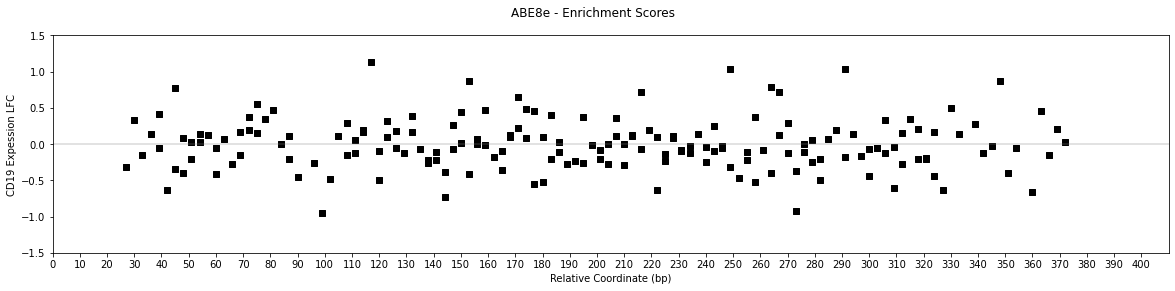

In [203]:
reverse_sign = False
plot_replicates = False
figsize=(20, 4)
fig = plt.figure(figsize=figsize)
fig.suptitle("{} - Enrichment Scores".format("ABE8e"))
ax = fig.add_subplot(111)

lfc_rep1 = np.asarray([guide_info[0] for guide_info in abe8e_guide_info_list])
lfc_rep2 = np.asarray([guide_info[1] for guide_info in abe8e_guide_info_list])
lfc_rep3 = np.asarray([guide_info[2] for guide_info in abe8e_guide_info_list])
lfc_mean = np.asarray([guide_info[3] for guide_info in abe8e_guide_info_list])
positions = np.asarray([guide_info[4] for guide_info in abe8e_guide_info_list]) - 28930650.0

multiplier = 1
if reverse_sign:
    multiplier = -1

if plot_replicates:
    for lfc_rep in [lfc_rep1, lfc_rep2, lfc_rep3]:
        ax.scatter(positions, lfc_rep*multiplier, s=20, alpha=1)

ax.scatter(positions, lfc_mean*multiplier, alpha=1, marker="s", color="black", s=40, label="Test")

ax.axhline(y = 0, color = 'grey', alpha=0.3)

ax.set_xlabel("Relative Coordinate (bp)")
ax.set_ylabel("CD19 Expession LFC")

#if xlim:
#    ax.set_xlim(xlim[0], xlim[1])
#if ylim:
#    ax.set_ylim(ylim[0], ylim[1])

#if xlim:
#    ax.set_xticks(np.arange(xlim[0], xlim[1], 10))
#else:
#    if amplicon_position == True:
#        ax.set_xticks(np.arange(0, max(positions)+1, 10))
#    else:
#        ax.set_xticks(np.arange(min(positions), max(positions)+1, 10))
#if legend:
#    leg = ax.legend()
#    for lh in leg.legend_handles: 
#        lh.set_alpha(1)
ax.set_ylim(-1.5, 1.5)
ax.set_xlim(0, 410)
ax.set_xticks(np.arange(0, 410, 10))
plt.show()

### Archived Code

In [ ]:
#[perform_count(input_fn=fn,output_fn=f"cd19_abe8e_presort_count_hamming7_{index}", guide_series=cd19_guide_series, hamming_distance=7) for index, fn in enumerate(cd19_abe8e_presort_fns.split(" "))]
#[perform_count(input_fn=fn,output_fn=f"cd19_abe8e_low_count_hamming7_{index}", guide_series=cd19_guide_series, hamming_distance=7) for index, fn in enumerate(cd19_abe8e_low_fns.split(" "))]
#[perform_count(input_fn=fn,output_fn=f"cd19_abe8e_plasmid_count_hamming7_{index}", guide_series=cd19_guide_series, hamming_distance=7) for index, fn in enumerate(cd19_abe8e_plasmid_fns.split(" "))]
#[perform_count(input_fn=fn,output_fn=f"cd19_abe8e_high_count_hamming7_{index}", guide_series=cd19_guide_series, hamming_distance=7) for index, fn in enumerate(cd19_abe8e_high_fns.split(" "))]

#cd19_abe8e_presort_count_result_list = [read_count(output_fn=f"cd19_abe8e_presort_count_hamming7_{index}") for index, fn in enumerate(cd19_abe8e_presort_fns.split(" "))]
#cd19_abe8e_low_count_result_list = [read_count(output_fn=f"cd19_abe8e_low_count_hamming7_{index}") for index, fn in enumerate(cd19_abe8e_low_fns.split(" "))]
#cd19_abe8e_plasmid_count_result_list = [read_count(output_fn=f"cd19_abe8e_plasmid_count_hamming7_{index}") for index, fn in enumerate(cd19_abe8e_plasmid_fns.split(" "))]
#cd19_abe8e_high_count_result_list = [read_count(output_fn=f"cd19_abe8e_high_count_hamming7_{index}") for index, fn in enumerate(cd19_abe8e_high_fns.split(" "))]


#print([count_result[2]["percent_mapped"] for count_result in cd19_abe8e_presort_count_result_list])
#print([count_result[2]["percent_mapped"] for count_result in cd19_abe8e_low_count_result_list])
#print([count_result[2]["percent_mapped"] for count_result in cd19_abe8e_plasmid_count_result_list])
#print([count_result[2]["percent_mapped"] for count_result in cd19_abe8e_high_count_result_list])

In [ ]:
cd19_guide_series

### Get neutral guides for CUT&RUN

10/20/2023

In [3]:
from Bio.Seq import Seq

amplicon_sequence = Seq("TACTCGCCCCCTTCATTCCCCTTCATTCATGCCTCATTCTTCCGCCTCCCAGCCGCCTCAACTGGCCAAAGGGAAGTGGAGGCCCTGCCACCTGTAGGGAGGGTCCCCTGGGGCTTGCCCACAGCAAACAGGAAGTCACAGCCTGGTGAGATGGGCCTGGGAATCAGCCACTGAGAAAGTGGGTCTCTTGGGTCCCTGAATTCTTTTTCTGAGTCCCTGCAGCAGTGAAAAAGACACAGAGGCACATAGAGAGTG")
amplicon_sequence_revcomp = amplicon_sequence.reverse_complement()

In [8]:
Seq("TACTCGCCCCCTTCATTCCC").reverse_complement()

Seq('GGGAATGAAGGGGGCGAGTA')

In [9]:
Seq("TTCATTCCCCTTCATTCATG").reverse_complement()

Seq('CATGAATGAAGGGGAATGAA')

In [10]:
Seq("TCATTCATGCCTCATTCTTC").reverse_complement()

Seq('GAAGAATGAGGCATGAATGA')